# Experiment 14: Isolate and Amplify the Effect

## Goal
Deep dive into the mechanics of multi-query/repetition amplification, answer length interaction, and LLM-generated surrogates. Build toward the best achievable deployment strategy.

## Five Investigations

### Investigation A: Repetition Scaling Curve (N=1000, MS MARCO)
How does the effect scale with repetition count (1, 2, 3, 5, 10, 20)? Does it saturate?
14 conditions: oracle repetitions at 1/2/3/5/10/20x, random-matched controls at 1/5/20x, real queries at different sims, gibberish control.

### Investigation B: Multi-Query Diversity Deep Dive (N=1000, MS MARCO)
When using multiple DIFFERENT queries, does diversity matter? Is 5 diverse queries better than 5 similar queries at the same total token count?
10 conditions comparing diverse vs similar selection, oracle anchoring, quality vs quantity.

### Investigation C: Answer Length Interaction + Goldilocks Zone (N=2000, MS MARCO)
Does answer length gate the effect? Reuse Exp 13B data, extend to 2000 samples, 2D analysis of difficulty x answer length.

### Investigation D: LLM-Generated Surrogates (N=500, MS MARCO)
Can LLM-generated queries replace historical click data for cold-start? 5 generation strategies, 8 scoring conditions.

### Investigation E: Interaction Analysis (uses data from A-D)
Do the effects compound? Three-way interaction, semantic component isolation, deployment simulation.

## Hypotheses
- A: Scaling is sublinear/saturating; semantic gap (oracle - random) stays constant with repetition
- B: Diverse queries > repeated single query at same token count; oracle anchor dominates
- C: Answer length positively correlates with delta within difficulty bins; Goldilocks zone exists
- D: LLM surrogates approach but don't match real query performance
- E: Best strategy combines hardness gating + multi-query on Goldilocks subset

In [1]:
# Ensure files created by this notebook are writable by all users
# (jupyter runs as uid=1000, CLI tools run as a different user)
import os
os.umask(0o000)

import sys, os, json, copy, time, datetime, re, string
from typing import Dict, List, Any, Optional, Tuple

import torch
import numpy as np
from tqdm.auto import tqdm
from scipy import stats
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120

sys.path.insert(0, '.')
from lib import (
    ExperimentConfig,
    build_kv_cache,
    score_answer_with_cache,
    extract_and_truncate_cache_with_bos,
    correct_rope_positions_with_bos,
    load_evaluation_samples,
    load_ms_marco,
    _ensure_dynamic_cache,
)
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, DynamicCache
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from datasets import load_dataset

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

config = ExperimentConfig(
    num_samples=8000,
    min_passage_words=50,
    max_passage_words=300,
    seed=SEED,
)

# Sample ranges
N_INV_A = 1000   # indices 0-999
N_INV_B = 1000   # indices 0-999 (same pool, filtered for >=5 queries at sim>=0.50)
N_INV_C = 2000   # indices 0-1999
N_INV_D = 500    # indices 2000-2499
INV_D_START = 2000

MQ_SEP = " "

os.makedirs("results/exp14", exist_ok=True)

print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

PyTorch: 2.10.0+cu128
CUDA: True
GPU: NVIDIA L4
GPU Memory: 23.6 GB


In [2]:
# ============================================================
# Load Model + Embedding Model
# ============================================================

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
)

print("Loading Mistral-7B...")
tokenizer = AutoTokenizer.from_pretrained(config.model_name)
model = AutoModelForCausalLM.from_pretrained(
    config.model_name,
    quantization_config=bnb_config,
    device_map="auto",
)
model.eval()
print(f"Model loaded. Layers: {model.config.num_hidden_layers}")

print("Loading embedding model...")
embed_model = SentenceTransformer('all-MiniLM-L6-v2')
print("Embedding model loaded.")

Loading Mistral-7B...


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

Model loaded. Layers: 32
Loading embedding model...


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Embedding model loaded.


In [3]:
# ============================================================
# Load MS MARCO, Build Query Pool, Embed
# ============================================================

print("Loading MS MARCO dataset...")
dataset = load_dataset(
    config.dataset_name, config.dataset_config,
    split=config.dataset_split, trust_remote_code=True
)
print(f"Dataset loaded: {len(dataset)} samples")

all_samples = load_evaluation_samples(dataset, config, require_answer=True)
print(f"Loaded {len(all_samples)} evaluation samples with answers")

# Build query pool from FULL dataset
print("\nBuilding query pool (full dataset)...")
query_pool = []
seen_queries = set()
for item in tqdm(dataset, desc="Extracting queries"):
    q = item.get('query', '').strip()
    if q and q not in seen_queries and len(q) > 10:
        query_pool.append(q)
        seen_queries.add(q)
print(f"Query pool size: {len(query_pool)}")

print("Embedding query pool...")
pool_embeddings = embed_model.encode(query_pool, show_progress_bar=True, batch_size=256)
print(f"Pool embeddings shape: {pool_embeddings.shape}")

# All samples we need (0-2499)
n_needed = INV_D_START + N_INV_D  # 2500
samples_all = all_samples[:n_needed]
print(f"\nUsing {len(samples_all)} samples total")

target_queries = [s['query'] for s in samples_all]
print("Embedding target queries...")
target_embeddings = embed_model.encode(target_queries, show_progress_bar=True, batch_size=256)
print(f"Target embeddings shape: {target_embeddings.shape}")

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'microsoft/ms_marco' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Loading MS MARCO dataset...
Dataset loaded: 10047 samples
Filtering samples...


Filtering:   0%|          | 0/10047 [00:00<?, ?it/s]

Selected 7365 samples
Loaded 7365 evaluation samples with answers

Building query pool (full dataset)...


Extracting queries:   0%|          | 0/10047 [00:00<?, ?it/s]

Query pool size: 10038
Embedding query pool...


Batches:   0%|          | 0/40 [00:00<?, ?it/s]

Pool embeddings shape: (10038, 384)

Using 2500 samples total
Embedding target queries...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Target embeddings shape: (2500, 384)


In [4]:
# ============================================================
# Helper Functions (from Exp 13 + new)
# ============================================================

def build_matched_bare_and_truncated(
    prefix_text, passage, model, tokenizer, config,
):
    """Build BPE-matched bare and truncated caches.
    Returns: (bare_len, bare_cache, keep_len, trunc_cache, prefix_token_len)
    """
    prefix_with_sep = prefix_text.strip() + " "
    prefix_encoding = tokenizer(
        prefix_with_sep, return_tensors="pt", add_special_tokens=True,
        padding=False, truncation=False
    )
    prefix_len = prefix_encoding['input_ids'].shape[1]

    full_context = prefix_with_sep + passage
    full_encoding = tokenizer(
        full_context, return_tensors="pt", add_special_tokens=True,
        padding=False, truncation=False
    )
    full_ids = full_encoding['input_ids'].to(config.device)
    doc_len = full_ids.shape[1] - prefix_len
    doc_token_ids = full_ids[:, prefix_len:]
    bos_id = full_ids[:, :1]
    bare_ids = torch.cat([bos_id, doc_token_ids], dim=1)
    bare_len = bare_ids.shape[1]

    with torch.no_grad():
        bare_out = model(
            input_ids=bare_ids,
            attention_mask=torch.ones_like(bare_ids),
            use_cache=True, return_dict=True
        )
    bare_cache = _ensure_dynamic_cache(bare_out.past_key_values)

    with torch.no_grad():
        full_out = model(
            input_ids=full_ids,
            attention_mask=torch.ones_like(full_ids),
            use_cache=True, return_dict=True
        )
    truncated = extract_and_truncate_cache_with_bos(full_out.past_key_values, doc_len)
    keep_len = 1 + doc_len
    assert bare_len == keep_len, f"Length mismatch: {bare_len} vs {keep_len}"

    surrogate_offset = prefix_len - 1
    correct_rope_positions_with_bos(truncated, surrogate_offset, model)

    return bare_len, bare_cache, keep_len, truncated, prefix_len


def find_queries_at_similarity(
    target_query, target_embedding, sim_low, sim_high,
    pool_queries, pool_embs, rng, k=5, diverse=True
):
    """Find k queries from pool in the given similarity range.
    If diverse=True, use greedy max-min distance selection.
    Returns list of (query_text, similarity) tuples.
    """
    sims = cosine_similarity([target_embedding], pool_embs)[0]
    # Exclude exact match
    for i in range(len(pool_queries)):
        if pool_queries[i].strip().lower() == target_query.strip().lower():
            sims[i] = -1

    mask = (sims >= sim_low) & (sims < sim_high)
    candidates = np.where(mask)[0]

    if len(candidates) == 0:
        return []
    if len(candidates) <= k:
        return [(pool_queries[i], float(sims[i])) for i in candidates]

    if diverse:
        # Greedy max-min distance selection
        cand_embs = pool_embs[candidates]
        selected = [rng.choice(len(candidates))]
        for _ in range(k - 1):
            sel_embs = cand_embs[selected]
            dists = 1 - cosine_similarity(cand_embs, sel_embs)
            min_dists = dists.min(axis=1)
            for s in selected:
                min_dists[s] = -1
            selected.append(np.argmax(min_dists))
        return [(pool_queries[candidates[i]], float(sims[candidates[i]])) for i in selected]
    else:
        # Random selection
        chosen = rng.choice(len(candidates), size=k, replace=False)
        return [(pool_queries[candidates[i]], float(sims[candidates[i]])) for i in chosen]


def find_queries_min_diversity(
    target_query, target_embedding, sim_low, sim_high,
    pool_queries, pool_embs, rng, k=5
):
    """Find k queries from pool that are most SIMILAR to each other (min diversity).
    Greedy min-max: start with closest pair, add closest to existing cluster.
    """
    sims = cosine_similarity([target_embedding], pool_embs)[0]
    for i in range(len(pool_queries)):
        if pool_queries[i].strip().lower() == target_query.strip().lower():
            sims[i] = -1

    mask = (sims >= sim_low) & (sims < sim_high)
    candidates = np.where(mask)[0]

    if len(candidates) <= k:
        return [(pool_queries[i], float(sims[i])) for i in candidates]

    # Pairwise similarity among candidates
    cand_embs = pool_embs[candidates]
    pair_sims = cosine_similarity(cand_embs)
    np.fill_diagonal(pair_sims, -1)

    # Start with the two most similar candidates
    flat_idx = np.argmax(pair_sims)
    i0, i1 = np.unravel_index(flat_idx, pair_sims.shape)
    selected = [i0, i1]

    for _ in range(k - 2):
        # For each candidate, compute mean similarity to selected
        sel_sims = pair_sims[:, selected].mean(axis=1)
        for s in selected:
            sel_sims[s] = -1
        selected.append(np.argmax(sel_sims))

    return [(pool_queries[candidates[i]], float(sims[candidates[i]])) for i in selected]


def build_multi_query_prefix(queries, sep=" "):
    """Concatenate multiple queries into a single prefix string."""
    return sep.join(q.strip() for q in queries)


def generate_with_prompt(passage, instruction, model, tokenizer, max_new_tokens=150):
    """Generate text using the model with a passage + instruction prompt."""
    prompt = f"[INST] {instruction}\n\nPassage: {passage[:1500]} [/INST]"
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=2048)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        output_ids = model.generate(
            **inputs, max_new_tokens=max_new_tokens,
            do_sample=False, pad_token_id=tokenizer.eos_token_id
        )
    generated = output_ids[0][inputs['input_ids'].shape[1]:]
    return tokenizer.decode(generated, skip_special_tokens=True).strip()


def parse_multiline(text, k=5):
    """Parse multi-line LLM output into individual queries.
    Strips numbering (1., 2., -, *) and returns first k non-empty lines.
    """
    lines = text.strip().split('\n')
    queries = []
    for line in lines:
        line = line.strip()
        # Strip common numbering patterns
        line = re.sub(r'^[\d]+[.)]\s*', '', line)
        line = re.sub(r'^[-*]\s*', '', line)
        line = line.strip()
        if len(line) > 3:
            queries.append(line)
        if len(queries) >= k:
            break
    return queries


def make_gibberish_tokens(tokenizer, target_token_count, rng):
    """Generate gibberish text by sampling random token IDs."""
    vocab_size = tokenizer.vocab_size
    # Sample random token IDs, avoiding special tokens (typically < 100)
    random_ids = rng.randint(100, vocab_size, size=target_token_count)
    text = tokenizer.decode(random_ids, skip_special_tokens=True)
    return text


def make_random_text_matched(tokenizer, target_token_count, rng, query_pool):
    """Generate random text matched to a target token count.
    Concatenate random queries from the pool until we reach the target.
    """
    text_parts = []
    total_tokens = 0
    indices = rng.permutation(len(query_pool))
    for idx in indices:
        q = query_pool[idx]
        q_tokens = len(tokenizer.encode(q, add_special_tokens=False))
        text_parts.append(q)
        total_tokens += q_tokens
        if total_tokens >= target_token_count:
            break
    text = " ".join(text_parts)
    # Trim to exact token count
    tokens = tokenizer.encode(text, add_special_tokens=False)[:target_token_count]
    return tokenizer.decode(tokens, skip_special_tokens=True)


def bootstrap_ci(data, n_bootstrap=10000, ci=0.95, stat_func=np.mean, seed=42):
    """Compute bootstrap confidence interval for a statistic."""
    rng = np.random.RandomState(seed)
    boot_stats = []
    for _ in range(n_bootstrap):
        sample = rng.choice(data, size=len(data), replace=True)
        boot_stats.append(stat_func(sample))
    boot_stats = np.array(boot_stats)
    alpha = (1 - ci) / 2
    return float(np.percentile(boot_stats, alpha * 100)), float(np.percentile(boot_stats, (1 - alpha) * 100))


def bootstrap_corr_ci(x, y, n_bootstrap=10000, ci=0.95, seed=42):
    """Bootstrap CI for Pearson correlation."""
    rng = np.random.RandomState(seed)
    rs = []
    n = len(x)
    for _ in range(n_bootstrap):
        idx = rng.choice(n, size=n, replace=True)
        r, _ = pearsonr(x[idx], y[idx])
        rs.append(r)
    rs = np.array(rs)
    alpha = (1 - ci) / 2
    return float(np.percentile(rs, alpha * 100)), float(np.percentile(rs, (1 - alpha) * 100))


print(f"Helper functions defined.")
print(f"  build_matched_bare_and_truncated")
print(f"  find_queries_at_similarity (diverse max-min)")
print(f"  find_queries_min_diversity (min diversity)")
print(f"  build_multi_query_prefix")
print(f"  generate_with_prompt (Mistral instruct format)")
print(f"  parse_multiline (strips numbering)")
print(f"  make_gibberish_tokens / make_random_text_matched")
print(f"  bootstrap_ci / bootstrap_corr_ci")

Helper functions defined.
  build_matched_bare_and_truncated
  find_queries_at_similarity (diverse max-min)
  find_queries_min_diversity (min diversity)
  build_multi_query_prefix
  generate_with_prompt (Mistral instruct format)
  parse_multiline (strips numbering)
  make_gibberish_tokens / make_random_text_matched
  bootstrap_ci / bootstrap_corr_ci


In [5]:
# ============================================================
# Compute Answer Token Lengths, Prepare Samples
# ============================================================

# Compute answer token lengths for all samples
print("Computing answer token lengths...")
answer_token_lengths = []
for s in tqdm(samples_all, desc="Answer lengths"):
    ans_toks = tokenizer.encode(s['answer'], add_special_tokens=False)
    answer_token_lengths.append(len(ans_toks))
answer_token_lengths = np.array(answer_token_lengths)
print(f"Answer token lengths: mean={answer_token_lengths.mean():.1f}, "
      f"median={np.median(answer_token_lengths):.1f}, "
      f"min={answer_token_lengths.min()}, max={answer_token_lengths.max()}")

# Pre-compute similarities for first 1000 target queries to pool
print("\nComputing target-to-pool similarities (first 1000)...")
target_pool_sims_1k = cosine_similarity(target_embeddings[:N_INV_A], pool_embeddings)
print(f"Similarity matrix shape: {target_pool_sims_1k.shape}")

Computing answer token lengths...


Answer lengths:   0%|          | 0/2500 [00:00<?, ?it/s]

Answer token lengths: mean=23.5, median=16.0, min=1, max=160

Computing target-to-pool similarities (first 1000)...
Similarity matrix shape: (1000, 10038)


In [6]:
# ============================================================
# Investigation A: Repetition Scaling — Surrogate Pre-Selection
# ============================================================

print("=" * 80)
print("INV A: REPETITION SCALING CURVE — SURROGATE PRE-SELECTION")
print("=" * 80)

rng_a = np.random.RandomState(SEED)
inv_a_surrogates = []

for i in tqdm(range(N_INV_A), desc="Inv A surrogates"):
    surr = {}
    tq = target_queries[i]
    te = target_embeddings[i]

    # Oracle query token count (for matching)
    oracle_toks = len(tokenizer.encode(tq, add_special_tokens=False))
    surr['oracle_token_count'] = oracle_toks

    # Real query at sim>=0.70 (for conditions 11-12)
    surr['real_070'] = find_queries_at_similarity(
        tq, te, 0.70, 1.0, query_pool, pool_embeddings, rng_a, k=1, diverse=False)

    # Real query at sim in [0.25, 0.35] (for condition 13: low-sim)
    surr['real_030'] = find_queries_at_similarity(
        tq, te, 0.25, 0.35, query_pool, pool_embeddings, rng_a, k=1, diverse=False)

    # Random text matched to oracle_1q token count
    surr['random_matched_1x'] = make_random_text_matched(
        tokenizer, oracle_toks, rng_a, query_pool)

    # For 5x: oracle repeated 5x token count
    oracle_5x_text = build_multi_query_prefix([tq] * 5, MQ_SEP)
    oracle_5x_toks = len(tokenizer.encode(oracle_5x_text, add_special_tokens=False))
    surr['oracle_5x_token_count'] = oracle_5x_toks
    surr['random_matched_5x'] = make_random_text_matched(
        tokenizer, oracle_5x_toks, rng_a, query_pool)

    # For 20x: oracle repeated 20x token count
    oracle_20x_text = build_multi_query_prefix([tq] * 20, MQ_SEP)
    oracle_20x_toks = len(tokenizer.encode(oracle_20x_text, add_special_tokens=False))
    surr['oracle_20x_token_count'] = oracle_20x_toks
    surr['random_matched_20x'] = make_random_text_matched(
        tokenizer, oracle_20x_toks, rng_a, query_pool)

    # Gibberish matched to oracle_5x token count
    surr['gibberish_matched_5x'] = make_gibberish_tokens(tokenizer, oracle_5x_toks, rng_a)

    inv_a_surrogates.append(surr)

# Summary
n_with_070 = sum(1 for s in inv_a_surrogates if s['real_070'])
n_with_030 = sum(1 for s in inv_a_surrogates if s['real_030'])
print(f"\nSurrogate selection complete:")
print(f"  Samples with real_070: {n_with_070}/{N_INV_A}")
print(f"  Samples with real_030: {n_with_030}/{N_INV_A}")
print(f"  Mean oracle token count: {np.mean([s['oracle_token_count'] for s in inv_a_surrogates]):.1f}")

INV A: REPETITION SCALING CURVE — SURROGATE PRE-SELECTION


Inv A surrogates:   0%|          | 0/1000 [00:00<?, ?it/s]


Surrogate selection complete:
  Samples with real_070: 233/1000
  Samples with real_030: 1000/1000
  Mean oracle token count: 7.9


In [7]:
# ============================================================
# Investigation A: Evaluation Loop (14 conditions x 1000 samples)
# ============================================================

print("=" * 80)
print("INV A: REPETITION SCALING — EVALUATION LOOP")
print("=" * 80)

CKPT_A = 'results/exp14/14_checkpoint_inv_a.json'
results_a = []
skipped_a = 0
errors_a = 0
start_a = time.time()

if os.path.exists(CKPT_A):
    with open(CKPT_A) as f:
        ckpt = json.load(f)
    results_a = ckpt.get('results', [])
    skipped_a = ckpt.get('skipped', 0)
    errors_a = ckpt.get('errors', 0)
    print(f"Resumed: {len(results_a)} results, {skipped_a} skipped, {errors_a} errors")

start_idx = len(results_a) + skipped_a + errors_a

for idx in tqdm(range(start_idx, N_INV_A), desc="Inv A eval",
                initial=start_idx, total=N_INV_A):
    sample = samples_all[idx]
    passage, query, answer = sample['passage'], sample['query'], sample['answer']
    answer_ids = tokenizer(answer, return_tensors='pt', add_special_tokens=False)['input_ids']
    if answer_ids.shape[1] < 2:
        skipped_a += 1
        continue

    query_prompt = config.query_template.format(query=query)
    surr = inv_a_surrogates[idx]

    try:
        result = {'idx': idx}

        # Condition 1: bare (use oracle as reference for BPE matching)
        bare_len, bare_cache, _, oracle_1x_cache, _ = \
            build_matched_bare_and_truncated(query, passage, model, tokenizer, config)
        nll_bare = score_answer_with_cache(
            bare_cache, bare_len, query_prompt, answer, model, tokenizer, config)
        result['nll_bare'] = nll_bare

        # Condition 2: oracle_1q (1x)
        result['nll_oracle_1x'] = score_answer_with_cache(
            oracle_1x_cache, bare_len, query_prompt, answer, model, tokenizer, config)

        # Conditions 3-7: oracle repeated 2x, 3x, 5x, 10x, 20x
        for rep_count, cond_name in [(2, 'oracle_2x'), (3, 'oracle_3x'),
                                      (5, 'oracle_5x'), (10, 'oracle_10x'), (20, 'oracle_20x')]:
            prefix = build_multi_query_prefix([query] * rep_count, MQ_SEP)
            _, _, kl, tc, _ = build_matched_bare_and_truncated(prefix, passage, model, tokenizer, config)
            result[f'nll_{cond_name}'] = score_answer_with_cache(
                tc, kl, query_prompt, answer, model, tokenizer, config)

        # Condition 8: random_matched_1x
        _, _, kl, tc, _ = build_matched_bare_and_truncated(
            surr['random_matched_1x'], passage, model, tokenizer, config)
        result['nll_random_matched_1x'] = score_answer_with_cache(
            tc, kl, query_prompt, answer, model, tokenizer, config)

        # Condition 9: random_matched_5x
        _, _, kl, tc, _ = build_matched_bare_and_truncated(
            surr['random_matched_5x'], passage, model, tokenizer, config)
        result['nll_random_matched_5x'] = score_answer_with_cache(
            tc, kl, query_prompt, answer, model, tokenizer, config)

        # Condition 10: random_matched_20x
        _, _, kl, tc, _ = build_matched_bare_and_truncated(
            surr['random_matched_20x'], passage, model, tokenizer, config)
        result['nll_random_matched_20x'] = score_answer_with_cache(
            tc, kl, query_prompt, answer, model, tokenizer, config)

        # Condition 11: real_070_1x
        if surr['real_070']:
            rq, rs = surr['real_070'][0]
            _, _, kl, tc, _ = build_matched_bare_and_truncated(rq, passage, model, tokenizer, config)
            result['nll_real_070_1x'] = score_answer_with_cache(
                tc, kl, query_prompt, answer, model, tokenizer, config)
            result['real_070_sim'] = rs

            # Condition 12: real_070_5x
            prefix_5x = build_multi_query_prefix([rq] * 5, MQ_SEP)
            _, _, kl, tc, _ = build_matched_bare_and_truncated(prefix_5x, passage, model, tokenizer, config)
            result['nll_real_070_5x'] = score_answer_with_cache(
                tc, kl, query_prompt, answer, model, tokenizer, config)

        # Condition 13: real_030_5x
        if surr['real_030']:
            rq, rs = surr['real_030'][0]
            prefix_5x = build_multi_query_prefix([rq] * 5, MQ_SEP)
            _, _, kl, tc, _ = build_matched_bare_and_truncated(prefix_5x, passage, model, tokenizer, config)
            result['nll_real_030_5x'] = score_answer_with_cache(
                tc, kl, query_prompt, answer, model, tokenizer, config)
            result['real_030_sim'] = rs

        # Condition 14: gibberish_matched_5x
        _, _, kl, tc, _ = build_matched_bare_and_truncated(
            surr['gibberish_matched_5x'], passage, model, tokenizer, config)
        result['nll_gibberish_matched_5x'] = score_answer_with_cache(
            tc, kl, query_prompt, answer, model, tokenizer, config)

        results_a.append(result)

    except Exception as e:
        errors_a += 1
        print(f"\n  Error at idx {idx}: {e}")
        if errors_a > 20:
            print("Too many errors, stopping Inv A")
            break

    # Checkpoint every 25
    if (idx + 1) % 25 == 0:
        with open(CKPT_A, 'w') as f:
            json.dump({'results': results_a, 'skipped': skipped_a, 'errors': errors_a}, f)
        elapsed = time.time() - start_a
        rate = (idx - start_idx + 1) / elapsed * 3600
        print(f"\n  [{idx+1}/{N_INV_A} | {elapsed/60:.0f}m | {rate:.0f}/hr | "
              f"{len(results_a)} results, {skipped_a} skip, {errors_a} err]")

# Final checkpoint
with open(CKPT_A, 'w') as f:
    json.dump({'results': results_a, 'skipped': skipped_a, 'errors': errors_a}, f)

elapsed_a = time.time() - start_a
print(f"\nInv A complete: {len(results_a)} results, {skipped_a} skipped, "
      f"{errors_a} errors in {elapsed_a/60:.1f}m")

INV A: REPETITION SCALING — EVALUATION LOOP


Inv A eval:   0%|          | 0/1000 [00:00<?, ?it/s]


  [25/1000 | 5m | 322/hr | 23 results, 2 skip, 0 err]

  [75/1000 | 14m | 325/hr | 66 results, 9 skip, 0 err]

  [100/1000 | 19m | 313/hr | 91 results, 9 skip, 0 err]

  [125/1000 | 24m | 313/hr | 114 results, 11 skip, 0 err]

  [150/1000 | 29m | 313/hr | 136 results, 14 skip, 0 err]

  [175/1000 | 33m | 320/hr | 155 results, 20 skip, 0 err]

  [200/1000 | 38m | 317/hr | 178 results, 22 skip, 0 err]

  [225/1000 | 43m | 315/hr | 202 results, 23 skip, 0 err]

  [250/1000 | 48m | 312/hr | 227 results, 23 skip, 0 err]

  [275/1000 | 53m | 312/hr | 250 results, 25 skip, 0 err]

  [300/1000 | 58m | 311/hr | 273 results, 27 skip, 0 err]

  [350/1000 | 68m | 309/hr | 320 results, 30 skip, 0 err]

  [375/1000 | 73m | 309/hr | 344 results, 31 skip, 0 err]

  [400/1000 | 78m | 310/hr | 366 results, 34 skip, 0 err]

  [425/1000 | 83m | 309/hr | 390 results, 35 skip, 0 err]

  [450/1000 | 87m | 310/hr | 412 results, 38 skip, 0 err]

  [475/1000 | 92m | 311/hr | 434 results, 41 skip, 0 err]

  [50

INV A: REPETITION SCALING — ANALYSIS

Condition                     N     Win%      Delta    Cohen d      p-value
---------------------------------------------------------------------------
bare                        919              1.2528
oracle_1x                   919    63.2%    +0.0686      0.156     2.43e-06
oracle_2x                   919    64.9%    +0.0734      0.152     4.71e-06
oracle_3x                   919    65.3%    +0.0793      0.167     4.75e-07
oracle_5x                   919    67.6%    +0.0913      0.194     5.81e-09
oracle_10x                  919    67.6%    +0.0864      0.182     4.69e-08
oracle_20x                  919    65.4%    +0.0749      0.158     1.97e-06
random_matched_1x           919    58.3%    +0.0477      0.127     1.26e-04
random_matched_5x           919    57.6%    +0.0470      0.121     2.50e-04
random_matched_20x          919    60.1%    +0.0356      0.081     1.46e-02
real_070_1x                 220    69.1%    +0.0694      0.150     2.69e-0

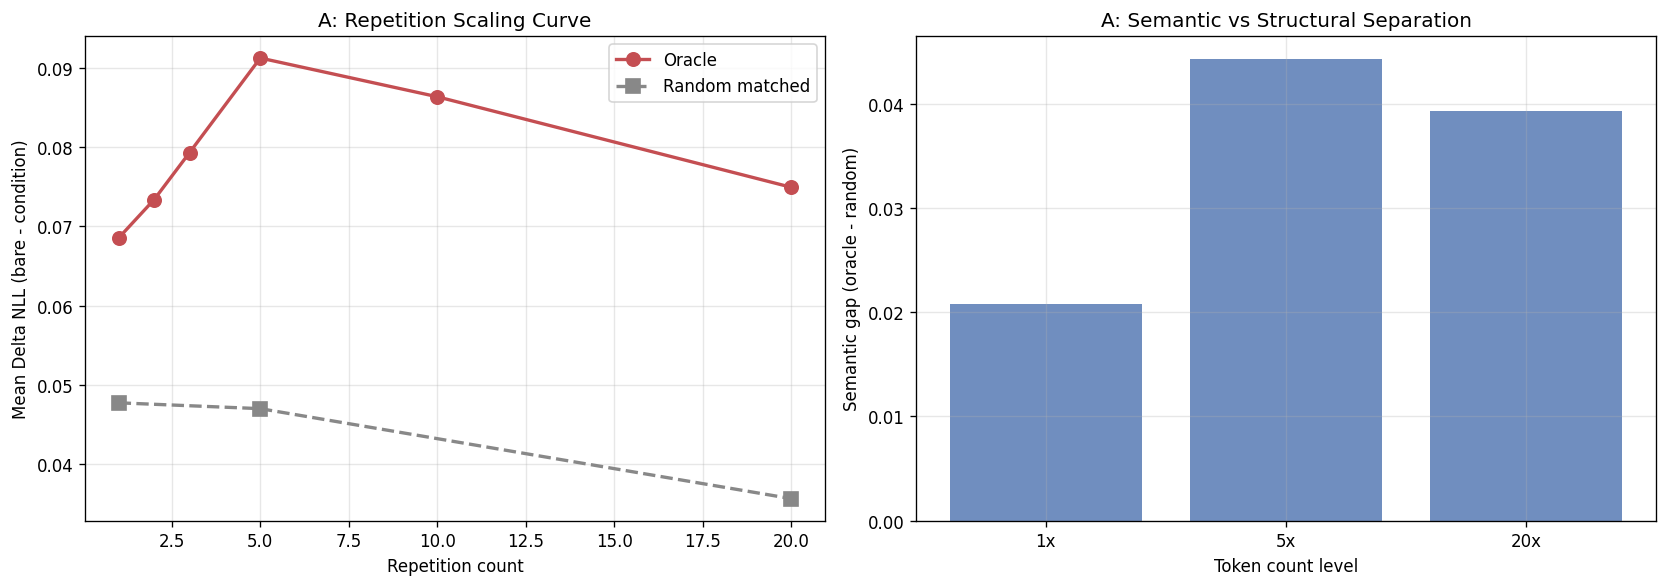

Saved: results/exp14/14_inv_a_scaling.png


In [8]:
# ============================================================
# Investigation A: Analysis — Scaling Curve, Structural vs Semantic
# ============================================================

print("=" * 80)
print("INV A: REPETITION SCALING — ANALYSIS")
print("=" * 80)

# --- Condition summary table ---
conds_a = [
    ('bare', 'nll_bare'),
    ('oracle_1x', 'nll_oracle_1x'),
    ('oracle_2x', 'nll_oracle_2x'),
    ('oracle_3x', 'nll_oracle_3x'),
    ('oracle_5x', 'nll_oracle_5x'),
    ('oracle_10x', 'nll_oracle_10x'),
    ('oracle_20x', 'nll_oracle_20x'),
    ('random_matched_1x', 'nll_random_matched_1x'),
    ('random_matched_5x', 'nll_random_matched_5x'),
    ('random_matched_20x', 'nll_random_matched_20x'),
    ('real_070_1x', 'nll_real_070_1x'),
    ('real_070_5x', 'nll_real_070_5x'),
    ('real_030_5x', 'nll_real_030_5x'),
    ('gibberish_matched_5x', 'nll_gibberish_matched_5x'),
]

print(f"\n{'Condition':<25} {'N':>5} {'Win%':>8} {'Delta':>10} {'Cohen d':>10} {'p-value':>12}")
print("-" * 75)

stats_a = {}
for cname, nll_key in conds_a:
    valid = [r for r in results_a if r.get(nll_key) is not None]
    if len(valid) < 10:
        print(f"{cname:<25} {len(valid):>5} -- insufficient")
        continue
    nlls = np.array([r[nll_key] for r in valid])
    bares = np.array([r['nll_bare'] for r in valid])
    if cname == 'bare':
        print(f"{cname:<25} {len(valid):>5} {'':>8} {np.mean(nlls):>10.4f}")
        stats_a[cname] = {'n': len(valid), 'mean_nll': float(np.mean(nlls))}
        continue
    deltas = bares - nlls
    wr = np.mean(deltas > 0) * 100
    d = np.mean(deltas) / np.std(deltas, ddof=1) if np.std(deltas) > 0 else 0
    t, p = stats.ttest_rel(bares, nlls)
    print(f"{cname:<25} {len(valid):>5} {wr:>7.1f}% {np.mean(deltas):>+10.4f} {d:>10.3f} {p:>12.2e}")
    stats_a[cname] = {
        'n': len(valid), 'win_rate': float(wr), 'mean_delta': float(np.mean(deltas)),
        'cohens_d': float(d), 'p_value': float(p),
    }

# --- Scaling curve ---
print("\n--- Scaling Curve ---")
rep_counts = [1, 2, 3, 5, 10, 20]
oracle_conds = ['oracle_1x', 'oracle_2x', 'oracle_3x', 'oracle_5x', 'oracle_10x', 'oracle_20x']
oracle_ds = []
oracle_reps = []
for rc, oc in zip(rep_counts, oracle_conds):
    if oc in stats_a:
        oracle_ds.append(stats_a[oc]['mean_delta'])
        oracle_reps.append(rc)
        print(f"  {rc}x: delta={stats_a[oc]['mean_delta']:+.4f}, d={stats_a[oc]['cohens_d']:.3f}")

# Random-matched for comparison
random_ds = []
for rc, rc_name in [(1, 'random_matched_1x'), (5, 'random_matched_5x'), (20, 'random_matched_20x')]:
    if rc_name in stats_a:
        random_ds.append((rc, stats_a[rc_name]['mean_delta']))

# --- Structural vs semantic separation ---
print("\n--- Structural vs Semantic Separation ---")
for tc, oc, rc in [(1, 'oracle_1x', 'random_matched_1x'),
                    (5, 'oracle_5x', 'random_matched_5x'),
                    (20, 'oracle_20x', 'random_matched_20x')]:
    if oc in stats_a and rc in stats_a:
        gap = stats_a[oc]['mean_delta'] - stats_a[rc]['mean_delta']
        print(f"  {tc}x tokens: oracle={stats_a[oc]['mean_delta']:+.4f}, "
              f"random={stats_a[rc]['mean_delta']:+.4f}, "
              f"semantic gap={gap:+.4f}")

# --- Similarity x repetition ---
print("\n--- Similarity x Repetition ---")
if 'real_070_5x' in stats_a and 'real_030_5x' in stats_a:
    print(f"  real_070_5x: d={stats_a['real_070_5x']['cohens_d']:.3f}, "
          f"delta={stats_a['real_070_5x']['mean_delta']:+.4f}")
    print(f"  real_030_5x: d={stats_a['real_030_5x']['cohens_d']:.3f}, "
          f"delta={stats_a['real_030_5x']['mean_delta']:+.4f}")
    # Head-to-head
    matched = [r for r in results_a if r.get('nll_real_070_5x') is not None
               and r.get('nll_real_030_5x') is not None]
    if len(matched) >= 10:
        high_nlls = np.array([r['nll_real_070_5x'] for r in matched])
        low_nlls = np.array([r['nll_real_030_5x'] for r in matched])
        t, p = stats.ttest_rel(low_nlls, high_nlls)
        wr = np.mean(high_nlls < low_nlls) * 100
        print(f"  Head-to-head (N={len(matched)}): real_070_5x wins {wr:.1f}%, p={p:.4f}")

# --- Coherence check ---
print("\n--- Coherence: Gibberish vs Random ---")
if 'gibberish_matched_5x' in stats_a and 'random_matched_5x' in stats_a:
    print(f"  gibberish_5x: d={stats_a['gibberish_matched_5x']['cohens_d']:.3f}")
    print(f"  random_5x:    d={stats_a['random_matched_5x']['cohens_d']:.3f}")
    matched = [r for r in results_a if r.get('nll_gibberish_matched_5x') is not None
               and r.get('nll_random_matched_5x') is not None]
    if len(matched) >= 10:
        g_nlls = np.array([r['nll_gibberish_matched_5x'] for r in matched])
        r_nlls = np.array([r['nll_random_matched_5x'] for r in matched])
        t, p = stats.ttest_rel(r_nlls, g_nlls)
        wr = np.mean(r_nlls < g_nlls) * 100
        print(f"  Head-to-head (N={len(matched)}): random wins {wr:.1f}%, p={p:.4f}")

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scaling curve
ax = axes[0]
if oracle_reps:
    ax.plot(oracle_reps, oracle_ds, 'o-', color='#c44e52', linewidth=2, markersize=8, label='Oracle')
if random_ds:
    ax.plot([r[0] for r in random_ds], [r[1] for r in random_ds],
            's--', color='#888888', linewidth=2, markersize=8, label='Random matched')
ax.set_xlabel('Repetition count')
ax.set_ylabel('Mean Delta NLL (bare - condition)')
ax.set_title('A: Repetition Scaling Curve')
ax.legend()
ax.grid(True, alpha=0.3)

# Semantic gap
ax = axes[1]
gaps = []
gap_reps = []
for tc, oc, rc in [(1, 'oracle_1x', 'random_matched_1x'),
                    (5, 'oracle_5x', 'random_matched_5x'),
                    (20, 'oracle_20x', 'random_matched_20x')]:
    if oc in stats_a and rc in stats_a:
        gaps.append(stats_a[oc]['mean_delta'] - stats_a[rc]['mean_delta'])
        gap_reps.append(tc)
if gaps:
    ax.bar(range(len(gaps)), gaps, color='#4c72b0', alpha=0.8)
    ax.set_xticks(range(len(gaps)))
    ax.set_xticklabels([f'{r}x' for r in gap_reps])
    ax.set_xlabel('Token count level')
    ax.set_ylabel('Semantic gap (oracle - random)')
    ax.set_title('A: Semantic vs Structural Separation')
    ax.axhline(y=0, color='black', linewidth=0.5)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/exp14/14_inv_a_scaling.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: results/exp14/14_inv_a_scaling.png")

In [9]:
# ============================================================
# Investigation B: Diversity Deep Dive — Surrogate Pre-Selection
# ============================================================

print("=" * 80)
print("INV B: DIVERSITY DEEP DIVE — SURROGATE PRE-SELECTION")
print("=" * 80)

rng_b = np.random.RandomState(SEED + 1)
inv_b_surrogates = []
inv_b_eligible = []  # indices of samples with >=5 queries at sim>=0.50

for i in tqdm(range(N_INV_B), desc="Inv B surrogates"):
    tq = target_queries[i]
    te = target_embeddings[i]

    # Check: does this sample have >=5 queries at sim>=0.50?
    all_050 = find_queries_at_similarity(
        tq, te, 0.50, 1.0, query_pool, pool_embeddings, rng_b, k=20, diverse=True)
    if len(all_050) < 5:
        inv_b_surrogates.append(None)
        continue

    inv_b_eligible.append(i)
    surr = {}

    # Diverse 5q at sim>=0.50 (max-min distance)
    surr['diverse_5q_050'] = find_queries_at_similarity(
        tq, te, 0.50, 1.0, query_pool, pool_embeddings, rng_b, k=5, diverse=True)

    # Similar 5q at sim>=0.50 (min diversity)
    surr['similar_5q_050'] = find_queries_min_diversity(
        tq, te, 0.50, 1.0, query_pool, pool_embeddings, rng_b, k=5)

    # Oracle + 4 diverse at sim>=0.50
    diverse_4 = find_queries_at_similarity(
        tq, te, 0.50, 1.0, query_pool, pool_embeddings, rng_b, k=4, diverse=True)
    surr['oracle_plus_4_diverse'] = diverse_4

    # Oracle + 4 most similar at sim>=0.50
    similar_4 = find_queries_min_diversity(
        tq, te, 0.50, 1.0, query_pool, pool_embeddings, rng_b, k=4)
    surr['oracle_plus_4_similar'] = similar_4

    # Best single query (highest sim in pool)
    sims = cosine_similarity([te], pool_embeddings)[0]
    for idx_p in range(len(query_pool)):
        if query_pool[idx_p].strip().lower() == tq.strip().lower():
            sims[idx_p] = -1
    best_idx = np.argmax(sims)
    surr['best_single'] = (query_pool[best_idx], float(sims[best_idx]))

    # Random 5q
    rand_idxs = rng_b.choice(len(query_pool), size=5, replace=False)
    surr['random_5q'] = [(query_pool[ri], 0.0) for ri in rand_idxs]

    # Diverse 3q at sim>=0.50
    surr['diverse_3q_050'] = find_queries_at_similarity(
        tq, te, 0.50, 1.0, query_pool, pool_embeddings, rng_b, k=3, diverse=True)

    # Diverse 5q at sim>=0.30
    surr['diverse_5q_030'] = find_queries_at_similarity(
        tq, te, 0.30, 1.0, query_pool, pool_embeddings, rng_b, k=5, diverse=True)

    inv_b_surrogates.append(surr)

print(f"\nEligible samples (>=5 queries at sim>=0.50): {len(inv_b_eligible)}/{N_INV_B}")

# Verify diverse vs similar have same mean sim but different spread
if inv_b_eligible:
    div_sims = []
    sim_sims = []
    for i in inv_b_eligible[:100]:
        surr = inv_b_surrogates[i]
        if surr is None:
            continue
        div_sims.extend([s for _, s in surr['diverse_5q_050']])
        sim_sims.extend([s for _, s in surr['similar_5q_050']])
    print(f"\nVerification (first 100 eligible):")
    print(f"  Diverse 5q: mean sim={np.mean(div_sims):.3f}, std={np.std(div_sims):.3f}")
    print(f"  Similar 5q: mean sim={np.mean(sim_sims):.3f}, std={np.std(sim_sims):.3f}")

INV B: DIVERSITY DEEP DIVE — SURROGATE PRE-SELECTION


Inv B surrogates:   0%|          | 0/1000 [00:00<?, ?it/s]


Eligible samples (>=5 queries at sim>=0.50): 305/1000

Verification (first 100 eligible):
  Diverse 5q: mean sim=0.562, std=0.067
  Similar 5q: mean sim=0.593, std=0.086


In [10]:
# ============================================================
# Investigation B: Evaluation Loop (10 conditions x eligible samples)
# ============================================================

print("=" * 80)
print("INV B: DIVERSITY DEEP DIVE — EVALUATION LOOP")
print("=" * 80)

CKPT_B = 'results/exp14/14_checkpoint_inv_b.json'
results_b = []
skipped_b = 0
errors_b = 0
start_b = time.time()

if os.path.exists(CKPT_B):
    with open(CKPT_B) as f:
        ckpt = json.load(f)
    results_b = ckpt.get('results', [])
    skipped_b = ckpt.get('skipped', 0)
    errors_b = ckpt.get('errors', 0)
    print(f"Resumed: {len(results_b)} results")

start_idx_b = len(results_b) + skipped_b + errors_b

for loop_idx in tqdm(range(start_idx_b, len(inv_b_eligible)), desc="Inv B eval",
                     initial=start_idx_b, total=len(inv_b_eligible)):
    idx = inv_b_eligible[loop_idx]
    sample = samples_all[idx]
    passage, query, answer = sample['passage'], sample['query'], sample['answer']
    answer_ids = tokenizer(answer, return_tensors='pt', add_special_tokens=False)['input_ids']
    if answer_ids.shape[1] < 2:
        skipped_b += 1
        continue

    query_prompt = config.query_template.format(query=query)
    surr = inv_b_surrogates[idx]

    try:
        result = {'idx': idx}

        # Condition 1: bare + Condition 2: oracle_1q
        bare_len, bare_cache, _, oracle_cache, _ = \
            build_matched_bare_and_truncated(query, passage, model, tokenizer, config)
        result['nll_bare'] = score_answer_with_cache(
            bare_cache, bare_len, query_prompt, answer, model, tokenizer, config)
        result['nll_oracle_1q'] = score_answer_with_cache(
            oracle_cache, bare_len, query_prompt, answer, model, tokenizer, config)

        # Condition 3: diverse_5q_050
        d5_queries = [q for q, s in surr['diverse_5q_050']]
        prefix = build_multi_query_prefix(d5_queries, MQ_SEP)
        _, _, kl, tc, _ = build_matched_bare_and_truncated(prefix, passage, model, tokenizer, config)
        result['nll_diverse_5q_050'] = score_answer_with_cache(
            tc, kl, query_prompt, answer, model, tokenizer, config)

        # Condition 4: similar_5q_050
        s5_queries = [q for q, s in surr['similar_5q_050']]
        prefix = build_multi_query_prefix(s5_queries, MQ_SEP)
        _, _, kl, tc, _ = build_matched_bare_and_truncated(prefix, passage, model, tokenizer, config)
        result['nll_similar_5q_050'] = score_answer_with_cache(
            tc, kl, query_prompt, answer, model, tokenizer, config)

        # Condition 5: oracle + 4 diverse
        d4_queries = [query] + [q for q, s in surr['oracle_plus_4_diverse']]
        prefix = build_multi_query_prefix(d4_queries, MQ_SEP)
        _, _, kl, tc, _ = build_matched_bare_and_truncated(prefix, passage, model, tokenizer, config)
        result['nll_oracle_plus_4_diverse'] = score_answer_with_cache(
            tc, kl, query_prompt, answer, model, tokenizer, config)

        # Condition 6: oracle + 4 similar
        s4_queries = [query] + [q for q, s in surr['oracle_plus_4_similar']]
        prefix = build_multi_query_prefix(s4_queries, MQ_SEP)
        _, _, kl, tc, _ = build_matched_bare_and_truncated(prefix, passage, model, tokenizer, config)
        result['nll_oracle_plus_4_similar'] = score_answer_with_cache(
            tc, kl, query_prompt, answer, model, tokenizer, config)

        # Condition 7: repeated_best_5x
        best_q, best_sim = surr['best_single']
        prefix = build_multi_query_prefix([best_q] * 5, MQ_SEP)
        _, _, kl, tc, _ = build_matched_bare_and_truncated(prefix, passage, model, tokenizer, config)
        result['nll_repeated_best_5x'] = score_answer_with_cache(
            tc, kl, query_prompt, answer, model, tokenizer, config)
        result['best_single_sim'] = best_sim

        # Condition 8: random_5q
        r5_queries = [q for q, s in surr['random_5q']]
        prefix = build_multi_query_prefix(r5_queries, MQ_SEP)
        _, _, kl, tc, _ = build_matched_bare_and_truncated(prefix, passage, model, tokenizer, config)
        result['nll_random_5q'] = score_answer_with_cache(
            tc, kl, query_prompt, answer, model, tokenizer, config)

        # Condition 9: diverse_3q_050
        d3_queries = [q for q, s in surr['diverse_3q_050']]
        prefix = build_multi_query_prefix(d3_queries, MQ_SEP)
        _, _, kl, tc, _ = build_matched_bare_and_truncated(prefix, passage, model, tokenizer, config)
        result['nll_diverse_3q_050'] = score_answer_with_cache(
            tc, kl, query_prompt, answer, model, tokenizer, config)

        # Condition 10: diverse_5q_030
        d5_030 = [q for q, s in surr['diverse_5q_030']]
        if len(d5_030) >= 5:
            prefix = build_multi_query_prefix(d5_030[:5], MQ_SEP)
            _, _, kl, tc, _ = build_matched_bare_and_truncated(prefix, passage, model, tokenizer, config)
            result['nll_diverse_5q_030'] = score_answer_with_cache(
                tc, kl, query_prompt, answer, model, tokenizer, config)

        results_b.append(result)

    except Exception as e:
        errors_b += 1
        print(f"\n  Error at idx {idx}: {e}")
        if errors_b > 20:
            print("Too many errors, stopping Inv B")
            break

    # Checkpoint every 25
    if (loop_idx + 1) % 25 == 0:
        with open(CKPT_B, 'w') as f:
            json.dump({'results': results_b, 'skipped': skipped_b, 'errors': errors_b}, f)
        elapsed = time.time() - start_b
        print(f"\n  [{loop_idx+1}/{len(inv_b_eligible)} | {elapsed/60:.0f}m | "
              f"{len(results_b)} results]")

# Final checkpoint
with open(CKPT_B, 'w') as f:
    json.dump({'results': results_b, 'skipped': skipped_b, 'errors': errors_b}, f)

elapsed_b = time.time() - start_b
print(f"\nInv B complete: {len(results_b)} results, {skipped_b} skipped, "
      f"{errors_b} errors in {elapsed_b/60:.1f}m")

INV B: DIVERSITY DEEP DIVE — EVALUATION LOOP


Inv B eval:   0%|          | 0/305 [00:00<?, ?it/s]


  [25/305 | 4m | 22 results]

  [75/305 | 11m | 67 results]

  [100/305 | 15m | 92 results]

  [125/305 | 19m | 116 results]

  [150/305 | 23m | 141 results]

  [175/305 | 27m | 164 results]

  [225/305 | 34m | 207 results]

  [250/305 | 38m | 230 results]

  [275/305 | 42m | 255 results]

Inv B complete: 281 results, 24 skipped, 0 errors in 46.5m


INV B: DIVERSITY DEEP DIVE — ANALYSIS

Condition                     N     Win%      Delta    Cohen d      p-value
---------------------------------------------------------------------------
bare                        281              1.4056
oracle_1q                   281    66.5%    +0.0886      0.168     5.24e-03
diverse_5q_050              281    65.1%    +0.1018      0.180     2.71e-03
similar_5q_050              281    68.0%    +0.1108      0.238     8.67e-05
oracle_plus_4_diverse       281    65.8%    +0.1178      0.244     5.53e-05
oracle_plus_4_similar       281    66.5%    +0.1043      0.201     8.58e-04
repeated_best_5x            281    68.7%    +0.1039      0.225     1.97e-04
random_5q                   281    63.0%    +0.0616      0.129     3.20e-02
diverse_3q_050              281    66.2%    +0.0990      0.215     3.61e-04
diverse_5q_030              281    68.7%    +0.1021      0.227     1.77e-04

--- Key Comparisons ---
  Diversity effect (N=281): diverse_5q_050 wins 

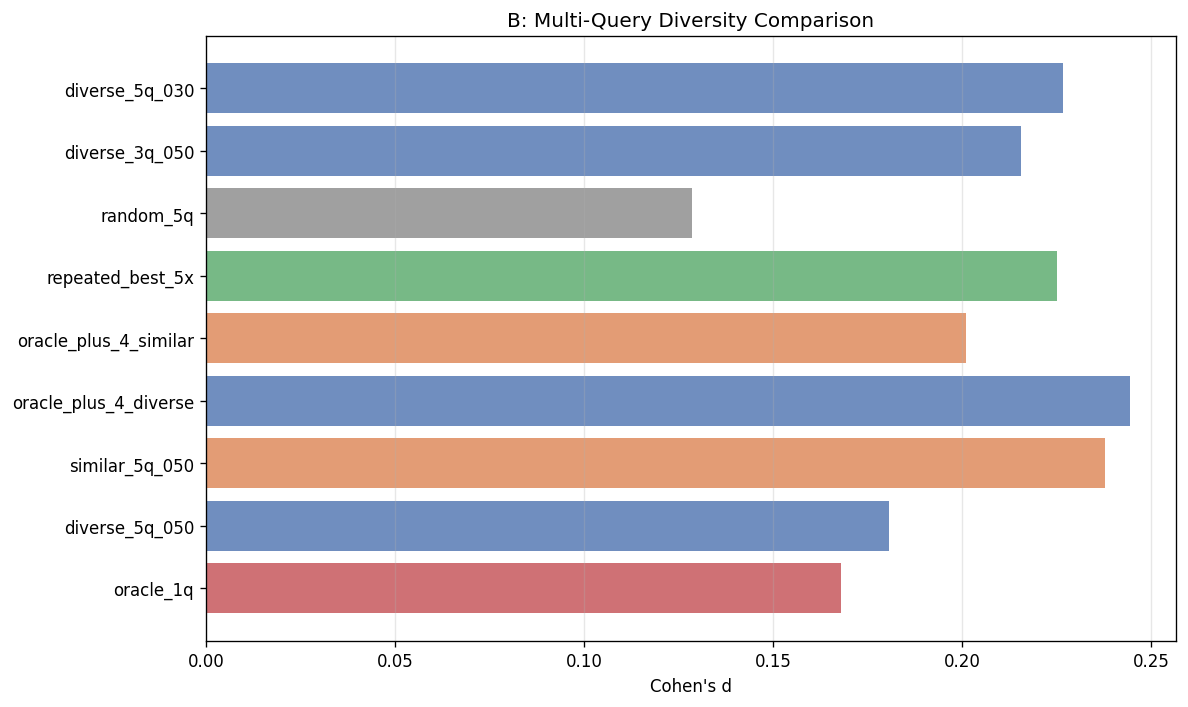

Saved: results/exp14/14_inv_b_diversity.png


In [11]:
# ============================================================
# Investigation B: Analysis — Diversity Effect, Quality vs Quantity
# ============================================================

print("=" * 80)
print("INV B: DIVERSITY DEEP DIVE — ANALYSIS")
print("=" * 80)

conds_b = [
    ('bare', 'nll_bare'), ('oracle_1q', 'nll_oracle_1q'),
    ('diverse_5q_050', 'nll_diverse_5q_050'), ('similar_5q_050', 'nll_similar_5q_050'),
    ('oracle_plus_4_diverse', 'nll_oracle_plus_4_diverse'),
    ('oracle_plus_4_similar', 'nll_oracle_plus_4_similar'),
    ('repeated_best_5x', 'nll_repeated_best_5x'),
    ('random_5q', 'nll_random_5q'),
    ('diverse_3q_050', 'nll_diverse_3q_050'),
    ('diverse_5q_030', 'nll_diverse_5q_030'),
]

print(f"\n{'Condition':<25} {'N':>5} {'Win%':>8} {'Delta':>10} {'Cohen d':>10} {'p-value':>12}")
print("-" * 75)

stats_b = {}
for cname, nll_key in conds_b:
    valid = [r for r in results_b if r.get(nll_key) is not None]
    if len(valid) < 10:
        print(f"{cname:<25} {len(valid):>5} -- insufficient")
        continue
    nlls = np.array([r[nll_key] for r in valid])
    bares = np.array([r['nll_bare'] for r in valid])
    if cname == 'bare':
        print(f"{cname:<25} {len(valid):>5} {'':>8} {np.mean(nlls):>10.4f}")
        stats_b[cname] = {'n': len(valid), 'mean_nll': float(np.mean(nlls))}
        continue
    deltas = bares - nlls
    wr = np.mean(deltas > 0) * 100
    d = np.mean(deltas) / np.std(deltas, ddof=1) if np.std(deltas) > 0 else 0
    t, p = stats.ttest_rel(bares, nlls)
    print(f"{cname:<25} {len(valid):>5} {wr:>7.1f}% {np.mean(deltas):>+10.4f} {d:>10.3f} {p:>12.2e}")
    stats_b[cname] = {
        'n': len(valid), 'win_rate': float(wr), 'mean_delta': float(np.mean(deltas)),
        'cohens_d': float(d), 'p_value': float(p),
    }

# Key comparisons
print("\n--- Key Comparisons ---")
comparisons = [
    ('diverse_5q_050', 'similar_5q_050', 'Diversity effect'),
    ('diverse_5q_050', 'repeated_best_5x', 'Diversity vs repetition'),
    ('oracle_plus_4_diverse', 'oracle_plus_4_similar', 'Oracle anchor: diverse vs similar'),
    ('diverse_5q_050', 'diverse_5q_030', 'Quality: sim>=0.50 vs sim>=0.30'),
    ('diverse_3q_050', 'diverse_5q_050', 'Diminishing returns: 3q vs 5q'),
]

for c1, c2, label in comparisons:
    matched = [r for r in results_b if r.get(f'nll_{c1}') is not None
               and r.get(f'nll_{c2}') is not None]
    if len(matched) < 10:
        print(f"  {label}: insufficient data ({len(matched)} matched)")
        continue
    n1 = np.array([r[f'nll_{c1}'] for r in matched])
    n2 = np.array([r[f'nll_{c2}'] for r in matched])
    t, p = stats.ttest_rel(n2, n1)  # positive t means c1 < c2 (c1 wins)
    wr = np.mean(n1 < n2) * 100
    print(f"  {label} (N={len(matched)}): {c1} wins {wr:.1f}%, p={p:.4f}")

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 6))

cond_names = []
cond_ds = []
cond_colors = []

for cname, nll_key in conds_b:
    if cname == 'bare' or cname not in stats_b:
        continue
    cond_names.append(cname)
    cond_ds.append(stats_b[cname]['cohens_d'])
    if 'diverse' in cname:
        cond_colors.append('#4c72b0')
    elif 'similar' in cname:
        cond_colors.append('#dd8452')
    elif 'oracle' in cname:
        cond_colors.append('#c44e52')
    elif 'random' in cname:
        cond_colors.append('#888888')
    elif 'repeated' in cname:
        cond_colors.append('#55a868')
    else:
        cond_colors.append('#8172b2')

y_pos = range(len(cond_names))
ax.barh(y_pos, cond_ds, color=cond_colors, alpha=0.8)
ax.set_yticks(y_pos)
ax.set_yticklabels(cond_names)
ax.set_xlabel("Cohen's d")
ax.set_title('B: Multi-Query Diversity Comparison')
ax.axvline(x=0, color='black', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('results/exp14/14_inv_b_diversity.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: results/exp14/14_inv_b_diversity.png")

In [12]:
# ============================================================
# Investigation C: Answer Length + Goldilocks — Eval Loop
# ============================================================

print("=" * 80)
print("INV C: ANSWER LENGTH + GOLDILOCKS ZONE")
print("=" * 80)

CKPT_C = 'results/exp14/14_checkpoint_inv_c.json'
results_c = []
skipped_c = 0
errors_c = 0
start_c = time.time()

if os.path.exists(CKPT_C):
    with open(CKPT_C) as f:
        ckpt = json.load(f)
    results_c = ckpt.get('results', [])
    skipped_c = ckpt.get('skipped', 0)
    errors_c = ckpt.get('errors', 0)
    print(f"Resumed: {len(results_c)} results")

start_idx_c = len(results_c) + skipped_c + errors_c
rng_c = np.random.RandomState(SEED + 2)

for idx in tqdm(range(start_idx_c, N_INV_C), desc="Inv C eval",
                initial=start_idx_c, total=N_INV_C):
    sample = samples_all[idx]
    passage, query, answer = sample['passage'], sample['query'], sample['answer']
    answer_ids = tokenizer(answer, return_tensors='pt', add_special_tokens=False)['input_ids']
    if answer_ids.shape[1] < 2:
        skipped_c += 1
        continue

    query_prompt = config.query_template.format(query=query)
    te = target_embeddings[idx]

    try:
        result = {'idx': idx, 'answer_token_len': int(answer_token_lengths[idx])}

        # bare + oracle_1q
        bare_len, bare_cache, _, oracle_cache, _ = \
            build_matched_bare_and_truncated(query, passage, model, tokenizer, config)
        result['nll_bare'] = score_answer_with_cache(
            bare_cache, bare_len, query_prompt, answer, model, tokenizer, config)
        result['nll_oracle_1q'] = score_answer_with_cache(
            oracle_cache, bare_len, query_prompt, answer, model, tokenizer, config)

        # oracle_5x
        prefix_5x = build_multi_query_prefix([query] * 5, MQ_SEP)
        _, _, kl, tc, _ = build_matched_bare_and_truncated(prefix_5x, passage, model, tokenizer, config)
        result['nll_oracle_5x'] = score_answer_with_cache(
            tc, kl, query_prompt, answer, model, tokenizer, config)

        # real_5q_050
        real_5q = find_queries_at_similarity(
            query, te, 0.50, 1.0, query_pool, pool_embeddings, rng_c, k=5, diverse=True)
        if len(real_5q) >= 5:
            rq_texts = [q for q, s in real_5q]
            prefix = build_multi_query_prefix(rq_texts, MQ_SEP)
            _, _, kl, tc, _ = build_matched_bare_and_truncated(prefix, passage, model, tokenizer, config)
            result['nll_real_5q_050'] = score_answer_with_cache(
                tc, kl, query_prompt, answer, model, tokenizer, config)

        results_c.append(result)

    except Exception as e:
        errors_c += 1
        print(f"\n  Error at idx {idx}: {e}")
        if errors_c > 20:
            print("Too many errors, stopping Inv C")
            break

    if (idx + 1) % 25 == 0:
        with open(CKPT_C, 'w') as f:
            json.dump({'results': results_c, 'skipped': skipped_c, 'errors': errors_c}, f)
        elapsed = time.time() - start_c
        print(f"\n  [{idx+1}/{N_INV_C} | {elapsed/60:.0f}m | {len(results_c)} results]")

# Final checkpoint
with open(CKPT_C, 'w') as f:
    json.dump({'results': results_c, 'skipped': skipped_c, 'errors': errors_c}, f)

elapsed_c = time.time() - start_c
print(f"\nInv C complete: {len(results_c)} results, {skipped_c} skipped, "
      f"{errors_c} errors in {elapsed_c/60:.1f}m")

INV C: ANSWER LENGTH + GOLDILOCKS ZONE


Inv C eval:   0%|          | 0/2000 [00:00<?, ?it/s]


  [25/2000 | 1m | 23 results]

  [75/2000 | 3m | 66 results]

  [100/2000 | 4m | 91 results]

  [125/2000 | 6m | 114 results]

  [150/2000 | 7m | 136 results]

  [175/2000 | 8m | 155 results]

  [200/2000 | 9m | 178 results]

  [225/2000 | 10m | 202 results]

  [250/2000 | 11m | 227 results]

  [275/2000 | 12m | 250 results]

  [300/2000 | 13m | 273 results]

  [350/2000 | 16m | 320 results]

  [375/2000 | 17m | 344 results]

  [400/2000 | 18m | 366 results]

  [425/2000 | 19m | 390 results]

  [450/2000 | 20m | 412 results]

  [475/2000 | 21m | 434 results]

  [500/2000 | 23m | 458 results]

  [525/2000 | 24m | 483 results]

  [550/2000 | 25m | 506 results]

  [575/2000 | 26m | 529 results]

  [600/2000 | 27m | 554 results]

  [625/2000 | 28m | 574 results]

  [675/2000 | 30m | 618 results]

  [700/2000 | 32m | 642 results]

  [725/2000 | 32m | 664 results]

  [750/2000 | 34m | 686 results]

  [775/2000 | 35m | 709 results]

  [800/2000 | 36m | 732 results]

  [825/2000 | 37m | 755 r

INV C: ANSWER LENGTH + GOLDILOCKS — ANALYSIS
N = 1839
Answer length: mean=25.3, median=18.0

--- Answer Length vs Delta (oracle_1q) ---
  Pearson r=-0.0252, p=2.80e-01
  Partial r (controlling bare_NLL)=0.0510, p=2.87e-02

--- 2D Heatmap: Mean Delta (oracle_1q) ---
                   Short   Med-Short    Med-Long        Long
        Easy     -0.0514     -0.0138      0.0024      0.0150  (N=164,97,90,105)
 Medium-Easy     -0.1358      0.0091      0.0409      0.0593  (N=41,64,152,206)
 Medium-Hard      0.0064      0.0511      0.1069      0.0915  (N=58,119,166,117)
        Hard      0.2856      0.2054      0.1183      0.0843  (N=170,165,83,42)

--- Gating Strategies (oracle_5x) ---
  Always oracle_1q: d=0.181
  Always oracle_5x: d=0.222
  P25 gate + oracle_5x: d=0.230 (priming 1383/1839)
  Goldilocks (P25 + long answer) + 5x: d=0.094 (priming 766/1839)


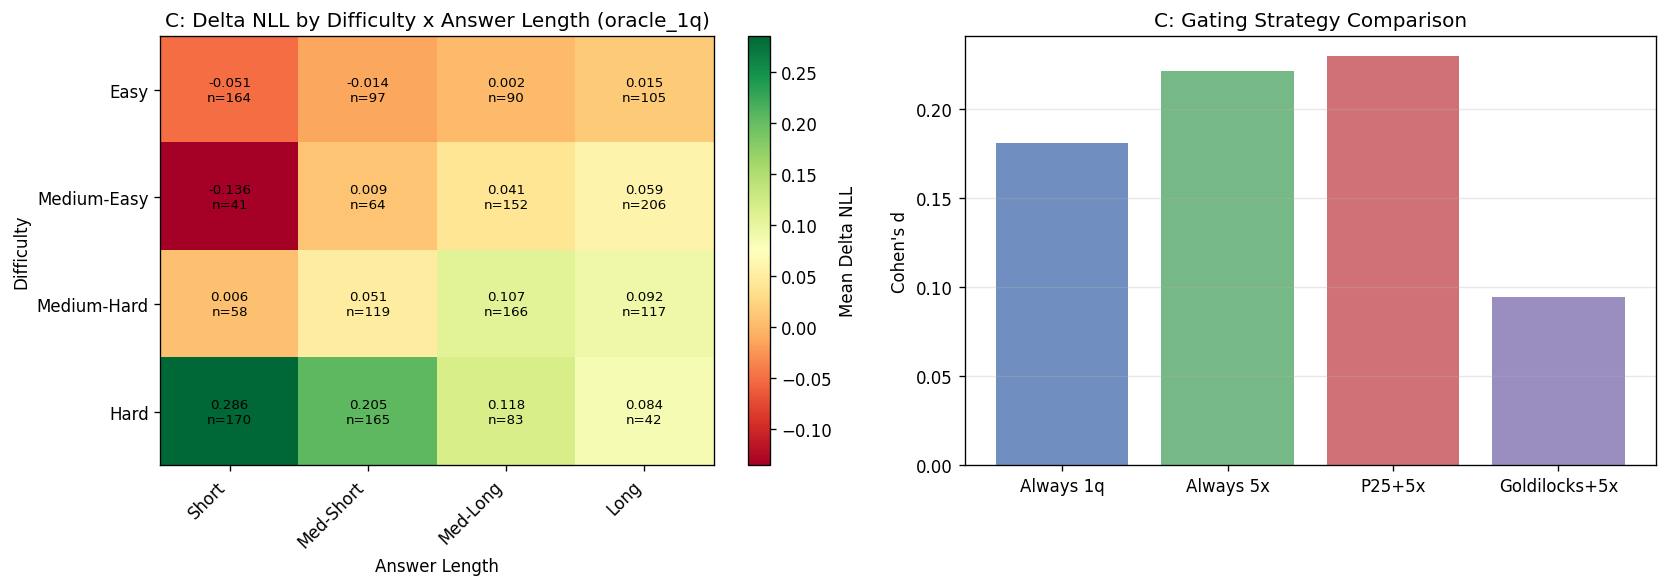

Saved: results/exp14/14_inv_c_goldilocks.png


In [13]:
# ============================================================
# Investigation C: Analysis — 2D Heatmap, Partial Correlation, Gating
# ============================================================

print("=" * 80)
print("INV C: ANSWER LENGTH + GOLDILOCKS — ANALYSIS")
print("=" * 80)

bare_c = np.array([r['nll_bare'] for r in results_c])
oracle_1q_c = np.array([r['nll_oracle_1q'] for r in results_c])
oracle_5x_c = np.array([r['nll_oracle_5x'] for r in results_c])
delta_1q = bare_c - oracle_1q_c
delta_5x = bare_c - oracle_5x_c
ans_lens_c = np.array([r['answer_token_len'] for r in results_c])

print(f"N = {len(results_c)}")
print(f"Answer length: mean={ans_lens_c.mean():.1f}, median={np.median(ans_lens_c):.1f}")

# --- Answer length effect ---
print("\n--- Answer Length vs Delta (oracle_1q) ---")
r_ans, p_ans = pearsonr(ans_lens_c.astype(float), delta_1q)
print(f"  Pearson r={r_ans:.4f}, p={p_ans:.2e}")

# Partial correlation: delta ~ answer_length | bare_NLL
z_bare = np.polyfit(bare_c, delta_1q, 1)
resid_delta = delta_1q - np.poly1d(z_bare)(bare_c)
z_bare_ans = np.polyfit(bare_c, ans_lens_c.astype(float), 1)
resid_ans = ans_lens_c.astype(float) - np.poly1d(z_bare_ans)(bare_c)
r_partial, p_partial = pearsonr(resid_ans, resid_delta)
print(f"  Partial r (controlling bare_NLL)={r_partial:.4f}, p={p_partial:.2e}")

# --- 2D Heatmap: difficulty x answer length ---
nll_bins = np.percentile(bare_c, [25, 50, 75])
ans_bins = np.percentile(ans_lens_c, [25, 50, 75])

nll_labels = ['Easy', 'Medium-Easy', 'Medium-Hard', 'Hard']
ans_labels = ['Short', 'Med-Short', 'Med-Long', 'Long']

heatmap_1q = np.zeros((4, 4))
heatmap_5x = np.zeros((4, 4))
heatmap_n = np.zeros((4, 4), dtype=int)

for ni, (nll_lo, nll_hi) in enumerate([(0, nll_bins[0]), (nll_bins[0], nll_bins[1]),
                                        (nll_bins[1], nll_bins[2]), (nll_bins[2], np.inf)]):
    for ai, (ans_lo, ans_hi) in enumerate([(0, ans_bins[0]), (ans_bins[0], ans_bins[1]),
                                            (ans_bins[1], ans_bins[2]), (ans_bins[2], np.inf)]):
        mask = (bare_c >= nll_lo) & (bare_c < nll_hi) & (ans_lens_c >= ans_lo) & (ans_lens_c < ans_hi)
        if mask.sum() > 0:
            heatmap_1q[ni, ai] = np.mean(delta_1q[mask])
            heatmap_5x[ni, ai] = np.mean(delta_5x[mask])
            heatmap_n[ni, ai] = mask.sum()

print("\n--- 2D Heatmap: Mean Delta (oracle_1q) ---")
print(f"{'':>12}", end='')
for al in ans_labels:
    print(f"{al:>12}", end='')
print()
for ni, nl in enumerate(nll_labels):
    print(f"{nl:>12}", end='')
    for ai in range(4):
        if heatmap_n[ni, ai] > 0:
            print(f"{heatmap_1q[ni, ai]:>12.4f}", end='')
        else:
            print(f"{'n/a':>12}", end='')
    print(f"  (N={','.join(str(heatmap_n[ni, ai]) for ai in range(4))})")

# --- Gating strategies ---
print("\n--- Gating Strategies (oracle_5x) ---")
nll_p25 = np.percentile(bare_c, 25)
nll_p50 = np.percentile(bare_c, 50)

d_always_1q = np.mean(delta_1q) / np.std(delta_1q, ddof=1) if np.std(delta_1q) > 0 else 0
d_always_5x = np.mean(delta_5x) / np.std(delta_5x, ddof=1) if np.std(delta_5x) > 0 else 0
print(f"  Always oracle_1q: d={d_always_1q:.3f}")
print(f"  Always oracle_5x: d={d_always_5x:.3f}")

# P25 gate + 5x
gate_mask = bare_c >= nll_p25
gated_delta = np.where(gate_mask, delta_5x, 0)
d_gated_5x = np.mean(gated_delta) / np.std(delta_5x, ddof=1) if np.std(delta_5x) > 0 else 0
print(f"  P25 gate + oracle_5x: d={d_gated_5x:.3f} (priming {gate_mask.sum()}/{len(bare_c)})")

# Goldilocks: P25 gate + answer_len >= median
gold_mask = (bare_c >= nll_p25) & (ans_lens_c >= np.median(ans_lens_c))
gold_delta = np.where(gold_mask, delta_5x, 0)
d_gold_5x = np.mean(gold_delta) / np.std(delta_5x, ddof=1) if np.std(delta_5x) > 0 else 0
print(f"  Goldilocks (P25 + long answer) + 5x: d={d_gold_5x:.3f} (priming {gold_mask.sum()}/{len(bare_c)})")

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
im = ax.imshow(heatmap_1q, cmap='RdYlGn', aspect='auto')
ax.set_xticks(range(4))
ax.set_xticklabels(ans_labels, rotation=45, ha='right')
ax.set_yticks(range(4))
ax.set_yticklabels(nll_labels)
ax.set_xlabel('Answer Length')
ax.set_ylabel('Difficulty')
ax.set_title('C: Delta NLL by Difficulty x Answer Length (oracle_1q)')
for ni in range(4):
    for ai in range(4):
        ax.text(ai, ni, f"{heatmap_1q[ni, ai]:.3f}\nn={heatmap_n[ni, ai]}",
                ha='center', va='center', fontsize=8)
plt.colorbar(im, ax=ax, label='Mean Delta NLL')

ax = axes[1]
strategies = ['Always 1q', 'Always 5x', 'P25+5x', 'Goldilocks+5x']
ds = [d_always_1q, d_always_5x, d_gated_5x, d_gold_5x]
colors = ['#4c72b0', '#55a868', '#c44e52', '#8172b2']
ax.bar(strategies, ds, color=colors, alpha=0.8)
ax.set_ylabel("Cohen's d")
ax.set_title('C: Gating Strategy Comparison')
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linewidth=0.5)

plt.tight_layout()
plt.savefig('results/exp14/14_inv_c_goldilocks.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: results/exp14/14_inv_c_goldilocks.png")

In [14]:
# ============================================================
# Investigation D: LLM Generation Loop (5 strategies x 500 samples)
# ============================================================

print("=" * 80)
print("INV D: LLM-GENERATED SURROGATES — GENERATION LOOP")
print("=" * 80)

CKPT_D_GEN = 'results/exp14/14_checkpoint_inv_d_gen.json'

GEN_PROMPTS = {
    'single_gen': "Write one short search query (3-8 words) a user would type to find this passage. Output only the query.",
    'diverse_5': "Write 5 diverse search queries different users might type to find this passage. One per line, no numbering.",
    'keyword_extract': "Extract 3-5 key search phrases from this passage, space-separated.",
    'intent_5': "List 5 different user intents this passage could satisfy. For each, write a short search query. One per line.",
    'adversarial': "Write a search query that would be very hard for a search engine to connect to this passage, but that this passage actually answers.",
}

gen_results = {}
if os.path.exists(CKPT_D_GEN):
    with open(CKPT_D_GEN) as f:
        gen_results = json.load(f)
    print(f"Resumed: {len(gen_results)} samples with generations")

start_d_gen = time.time()

for loop_idx in tqdm(range(N_INV_D), desc="Inv D generation"):
    idx = INV_D_START + loop_idx
    str_idx = str(idx)
    if str_idx in gen_results:
        continue

    sample = samples_all[idx]
    passage = sample['passage']

    gen = {}
    for strat_name, prompt in GEN_PROMPTS.items():
        try:
            output = generate_with_prompt(passage, prompt, model, tokenizer, max_new_tokens=150)
            gen[strat_name] = output
        except Exception as e:
            gen[strat_name] = f"ERROR: {e}"
            print(f"\n  Gen error [{strat_name}] sample {idx}: {e}")

    gen_results[str_idx] = gen

    if (loop_idx + 1) % 25 == 0:
        with open(CKPT_D_GEN, 'w') as f:
            json.dump(gen_results, f)
        elapsed = time.time() - start_d_gen
        print(f"\n  [{loop_idx+1} done | {elapsed/60:.0f}m]")

with open(CKPT_D_GEN, 'w') as f:
    json.dump(gen_results, f)

elapsed_gen = time.time() - start_d_gen
print(f"\nGeneration complete: {len(gen_results)} samples in {elapsed_gen/60:.1f}m")

# Show examples
for idx_str in list(gen_results.keys())[:3]:
    print(f"\n--- Sample {idx_str} ---")
    for strat, output in gen_results[idx_str].items():
        print(f"  {strat}: {output[:100]}...")

INV D: LLM-GENERATED SURROGATES — GENERATION LOOP


Inv D generation:   0%|          | 0/500 [00:00<?, ?it/s]


  [25 done | 13m]

  [50 done | 26m]

  [75 done | 39m]

  [100 done | 52m]

  [125 done | 65m]

  [150 done | 77m]

  [175 done | 90m]

  [200 done | 102m]

  [225 done | 115m]

  [250 done | 128m]

  [275 done | 140m]

  [300 done | 152m]

  [325 done | 164m]

  [350 done | 176m]

  [375 done | 188m]

  [400 done | 200m]

  [425 done | 213m]

  [450 done | 225m]

  [475 done | 237m]

  [500 done | 248m]

Generation complete: 500 samples in 248.2m

--- Sample 2000 ---
  single_gen: "Create bar graph Excel with titles" or "How to make Excel bar chart with axis titles"...
  diverse_5: 1. How to create a bar graph in Excel with titles for X and Y axis?
2. Excel steps to make a 2D colu...
  keyword_extract: 1. Make a bar graph
2. Highlight data
3. Include X and Y axis titles
4. Go to ' Insert' tab
5. Click...
  intent_5: 1. Intent: Creating a bar graph in Excel
   Search query: "How to make a bar graph in Excel with tit...
  adversarial: Query: "How to create a 2D column bar graph in Mic

In [15]:
# ============================================================
# Investigation D: Score Generated Surrogates (8 conditions x 500)
# ============================================================

print("=" * 80)
print("INV D: SCORE GENERATED SURROGATES")
print("=" * 80)

CKPT_D_SCORE = 'results/exp14/14_checkpoint_inv_d_score.json'
results_d = []
skipped_d = 0
errors_d = 0
start_d = time.time()
rng_d = np.random.RandomState(SEED + 3)

if os.path.exists(CKPT_D_SCORE):
    with open(CKPT_D_SCORE) as f:
        ckpt = json.load(f)
    results_d = ckpt.get('results', [])
    skipped_d = ckpt.get('skipped', 0)
    errors_d = ckpt.get('errors', 0)
    print(f"Resumed: {len(results_d)} results")

start_idx_d = len(results_d) + skipped_d + errors_d

for loop_idx in tqdm(range(start_idx_d, N_INV_D), desc="Inv D score",
                     initial=start_idx_d, total=N_INV_D):
    idx = INV_D_START + loop_idx
    sample = samples_all[idx]
    passage, query, answer = sample['passage'], sample['query'], sample['answer']
    answer_ids = tokenizer(answer, return_tensors='pt', add_special_tokens=False)['input_ids']
    if answer_ids.shape[1] < 2:
        skipped_d += 1
        continue

    query_prompt = config.query_template.format(query=query)
    gen = gen_results.get(str(idx), {})
    te = target_embeddings[idx]

    try:
        result = {'idx': idx}

        # Condition 1: bare
        bare_len, bare_cache, _, oracle_cache, _ = \
            build_matched_bare_and_truncated(query, passage, model, tokenizer, config)
        result['nll_bare'] = score_answer_with_cache(
            bare_cache, bare_len, query_prompt, answer, model, tokenizer, config)

        # Condition 2: single_gen_1x
        sg = gen.get('single_gen', '')
        if sg and not sg.startswith('ERROR'):
            sg_clean = sg.split('\n')[0].strip()
            if len(sg_clean) > 3:
                _, _, kl, tc, _ = build_matched_bare_and_truncated(sg_clean, passage, model, tokenizer, config)
                result['nll_single_gen_1x'] = score_answer_with_cache(
                    tc, kl, query_prompt, answer, model, tokenizer, config)

        # Condition 3: single_gen_5x
        if sg and not sg.startswith('ERROR'):
            sg_clean = sg.split('\n')[0].strip()
            if len(sg_clean) > 3:
                prefix = build_multi_query_prefix([sg_clean] * 5, MQ_SEP)
                _, _, kl, tc, _ = build_matched_bare_and_truncated(prefix, passage, model, tokenizer, config)
                result['nll_single_gen_5x'] = score_answer_with_cache(
                    tc, kl, query_prompt, answer, model, tokenizer, config)

        # Condition 4: diverse_5_raw
        d5 = gen.get('diverse_5', '')
        if d5 and not d5.startswith('ERROR'):
            d5_queries = parse_multiline(d5, k=5)
            if len(d5_queries) >= 3:
                prefix = build_multi_query_prefix(d5_queries, MQ_SEP)
                _, _, kl, tc, _ = build_matched_bare_and_truncated(prefix, passage, model, tokenizer, config)
                result['nll_diverse_5_raw'] = score_answer_with_cache(
                    tc, kl, query_prompt, answer, model, tokenizer, config)

        # Condition 5: keyword_raw
        kw = gen.get('keyword_extract', '')
        if kw and not kw.startswith('ERROR'):
            kw_clean = kw.strip()
            if len(kw_clean) > 3:
                _, _, kl, tc, _ = build_matched_bare_and_truncated(kw_clean, passage, model, tokenizer, config)
                result['nll_keyword_raw'] = score_answer_with_cache(
                    tc, kl, query_prompt, answer, model, tokenizer, config)

        # Condition 6: intent_5_raw
        i5 = gen.get('intent_5', '')
        if i5 and not i5.startswith('ERROR'):
            i5_queries = parse_multiline(i5, k=5)
            if len(i5_queries) >= 3:
                prefix = build_multi_query_prefix(i5_queries, MQ_SEP)
                _, _, kl, tc, _ = build_matched_bare_and_truncated(prefix, passage, model, tokenizer, config)
                result['nll_intent_5_raw'] = score_answer_with_cache(
                    tc, kl, query_prompt, answer, model, tokenizer, config)

        # Condition 7: real_baseline_1q (sim>=0.70)
        real_1q = find_queries_at_similarity(
            query, te, 0.70, 1.0, query_pool, pool_embeddings, rng_d, k=1, diverse=False)
        if real_1q:
            rq, rs = real_1q[0]
            _, _, kl, tc, _ = build_matched_bare_and_truncated(rq, passage, model, tokenizer, config)
            result['nll_real_baseline_1q'] = score_answer_with_cache(
                tc, kl, query_prompt, answer, model, tokenizer, config)

            # Condition 8: real_baseline_5x
            prefix = build_multi_query_prefix([rq] * 5, MQ_SEP)
            _, _, kl, tc, _ = build_matched_bare_and_truncated(prefix, passage, model, tokenizer, config)
            result['nll_real_baseline_5x'] = score_answer_with_cache(
                tc, kl, query_prompt, answer, model, tokenizer, config)

        results_d.append(result)

    except Exception as e:
        errors_d += 1
        print(f"\n  Error at idx {idx}: {e}")
        if errors_d > 20:
            print("Too many errors, stopping Inv D")
            break

    if (loop_idx + 1) % 25 == 0:
        with open(CKPT_D_SCORE, 'w') as f:
            json.dump({'results': results_d, 'skipped': skipped_d, 'errors': errors_d}, f)
        elapsed = time.time() - start_d
        print(f"\n  [{loop_idx+1}/{N_INV_D} | {elapsed/60:.0f}m | {len(results_d)} results]")

# Final checkpoint
with open(CKPT_D_SCORE, 'w') as f:
    json.dump({'results': results_d, 'skipped': skipped_d, 'errors': errors_d}, f)

elapsed_d = time.time() - start_d
print(f"\nInv D scoring complete: {len(results_d)} results, {skipped_d} skipped, "
      f"{errors_d} errors in {elapsed_d/60:.1f}m")

INV D: SCORE GENERATED SURROGATES


Inv D score:   0%|          | 0/500 [00:00<?, ?it/s]


  [50/500 | 5m | 48 results]

  [75/500 | 8m | 71 results]

  [100/500 | 11m | 94 results]

  [150/500 | 16m | 140 results]

  [175/500 | 19m | 164 results]

  [200/500 | 22m | 189 results]

  [225/500 | 24m | 214 results]

  [250/500 | 27m | 237 results]

  [275/500 | 30m | 260 results]

  [300/500 | 32m | 283 results]

  [350/500 | 37m | 324 results]

  [375/500 | 40m | 346 results]

  [400/500 | 42m | 371 results]

  [425/500 | 45m | 394 results]

  [450/500 | 48m | 416 results]

  [475/500 | 51m | 440 results]

  [500/500 | 53m | 460 results]

Inv D scoring complete: 460 results, 40 skipped, 0 errors in 52.7m


INV D: LLM-GENERATED SURROGATES — ANALYSIS

Condition                N     Win%      Delta    Cohen d      p-value
----------------------------------------------------------------------
bare                   460              1.3658
single_gen_1x          460    69.1%    +0.1039      0.292     9.14e-10
single_gen_5x          460    68.9%    +0.1127      0.274     7.93e-09
diverse_5_raw          460    71.1%    +0.1297      0.280     3.98e-09
keyword_raw            460    64.8%    +0.0940      0.200     2.24e-05
intent_5_raw           460    73.0%    +0.1330      0.274     7.65e-09
real_baseline_1q       116    62.1%    +0.0943      0.254     7.15e-03
real_baseline_5x       116    62.9%    +0.1266      0.292     2.08e-03

--- Key Comparisons ---
  repetition vs diversity (LLM) (N=460): single_gen_5x wins 42.8%, p=0.1348
  LLM diverse vs real 5x (N=116): diverse_5_raw wins 51.7%, p=0.3752
  LLM single vs real 1q (N=116): single_gen_1x wins 55.2%, p=0.8498

--- Generated Query Similarity 

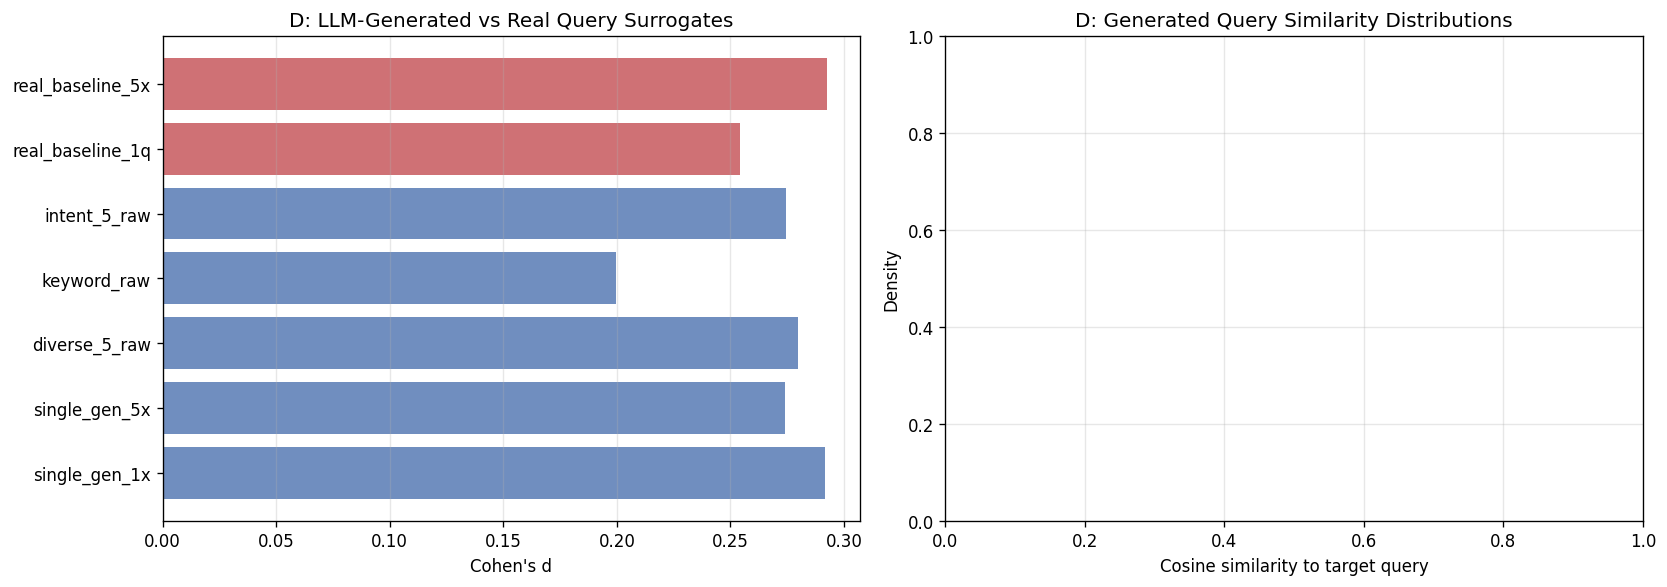

Saved: results/exp14/14_inv_d_llm_surrogates.png


In [16]:
# ============================================================
# Investigation D: Analysis — Compare Strategies, vs Real Baseline
# ============================================================

print("=" * 80)
print("INV D: LLM-GENERATED SURROGATES — ANALYSIS")
print("=" * 80)

conds_d = [
    ('bare', 'nll_bare'),
    ('single_gen_1x', 'nll_single_gen_1x'),
    ('single_gen_5x', 'nll_single_gen_5x'),
    ('diverse_5_raw', 'nll_diverse_5_raw'),
    ('keyword_raw', 'nll_keyword_raw'),
    ('intent_5_raw', 'nll_intent_5_raw'),
    ('real_baseline_1q', 'nll_real_baseline_1q'),
    ('real_baseline_5x', 'nll_real_baseline_5x'),
]

print(f"\n{'Condition':<20} {'N':>5} {'Win%':>8} {'Delta':>10} {'Cohen d':>10} {'p-value':>12}")
print("-" * 70)

stats_d = {}
for cname, nll_key in conds_d:
    valid = [r for r in results_d if r.get(nll_key) is not None]
    if len(valid) < 10:
        print(f"{cname:<20} {len(valid):>5} -- insufficient")
        continue
    nlls = np.array([r[nll_key] for r in valid])
    bares = np.array([r['nll_bare'] for r in valid])
    if cname == 'bare':
        print(f"{cname:<20} {len(valid):>5} {'':>8} {np.mean(nlls):>10.4f}")
        stats_d[cname] = {'n': len(valid), 'mean_nll': float(np.mean(nlls))}
        continue
    deltas = bares - nlls
    wr = np.mean(deltas > 0) * 100
    d = np.mean(deltas) / np.std(deltas, ddof=1) if np.std(deltas) > 0 else 0
    t, p = stats.ttest_rel(bares, nlls)
    print(f"{cname:<20} {len(valid):>5} {wr:>7.1f}% {np.mean(deltas):>+10.4f} {d:>10.3f} {p:>12.2e}")
    stats_d[cname] = {
        'n': len(valid), 'win_rate': float(wr), 'mean_delta': float(np.mean(deltas)),
        'cohens_d': float(d), 'p_value': float(p),
    }

# Key comparisons
print("\n--- Key Comparisons ---")
for c1, c2, label in [
    ('single_gen_5x', 'diverse_5_raw', 'repetition vs diversity (LLM)'),
    ('diverse_5_raw', 'real_baseline_5x', 'LLM diverse vs real 5x'),
    ('single_gen_1x', 'real_baseline_1q', 'LLM single vs real 1q'),
]:
    matched = [r for r in results_d if r.get(f'nll_{c1}') is not None
               and r.get(f'nll_{c2}') is not None]
    if len(matched) < 10:
        print(f"  {label}: insufficient data ({len(matched)})")
        continue
    n1 = np.array([r[f'nll_{c1}'] for r in matched])
    n2 = np.array([r[f'nll_{c2}'] for r in matched])
    t, p = stats.ttest_rel(n2, n1)
    wr = np.mean(n1 < n2) * 100
    print(f"  {label} (N={len(matched)}): {c1} wins {wr:.1f}%, p={p:.4f}")

# Similarity distributions of generated queries
print("\n--- Generated Query Similarity to Target ---")
for strat in ['single_gen', 'diverse_5', 'keyword_extract', 'intent_5', 'adversarial']:
    sims_list = []
    for loop_idx in range(N_INV_D):
        idx = INV_D_START + loop_idx
        gen = gen_results.get(str(idx), {})
        output = gen.get(strat, '')
        if not output or output.startswith('ERROR'):
            continue
        te = target_embeddings[idx]
        if strat in ['diverse_5', 'intent_5']:
            queries = parse_multiline(output, k=5)
        else:
            queries = [output.split('\n')[0].strip()]
        for q in queries:
            if len(q) > 3:
                q_emb = embed_model.encode([q])
                sim = cosine_similarity([te], q_emb)[0][0]
                sims_list.append(sim)
    if sims_list:
        print(f"  {strat}: mean_sim={np.mean(sims_list):.3f}, "
              f"median={np.median(sims_list):.3f}, n={len(sims_list)}")

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
strat_names = []
strat_ds = []
strat_colors = []
for cname, nll_key in conds_d:
    if cname == 'bare' or cname not in stats_d:
        continue
    strat_names.append(cname)
    strat_ds.append(stats_d[cname]['cohens_d'])
    if 'real' in cname:
        strat_colors.append('#c44e52')
    else:
        strat_colors.append('#4c72b0')

y_pos = range(len(strat_names))
ax.barh(y_pos, strat_ds, color=strat_colors, alpha=0.8)
ax.set_yticks(y_pos)
ax.set_yticklabels(strat_names)
ax.set_xlabel("Cohen's d")
ax.set_title('D: LLM-Generated vs Real Query Surrogates')
ax.axvline(x=0, color='black', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='x')

ax = axes[1]
ax.set_title('D: Generated Query Similarity Distributions')
ax.set_xlabel('Cosine similarity to target query')
ax.set_ylabel('Density')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/exp14/14_inv_d_llm_surrogates.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: results/exp14/14_inv_d_llm_surrogates.png")

In [17]:
# ============================================================
# Investigation E: Interaction Analysis (uses data from A-D)
# ============================================================

print("=" * 80)
print("INV E: INTERACTION ANALYSIS")
print("=" * 80)

# --- Semantic component isolation ---
print("--- Semantic Component Isolation ---")
print("At each token count, oracle - random = semantic delta")
print("Does the semantic gap grow, shrink, or stay constant?\n")

semantic_gaps = []
for tc, oc, rc in [(1, 'oracle_1x', 'random_matched_1x'),
                    (5, 'oracle_5x', 'random_matched_5x'),
                    (20, 'oracle_20x', 'random_matched_20x')]:
    if oc in stats_a and rc in stats_a:
        gap = stats_a[oc]['mean_delta'] - stats_a[rc]['mean_delta']
        semantic_gaps.append((tc, gap))
        print(f"  {tc}x tokens: semantic gap = {gap:+.4f}")

if len(semantic_gaps) >= 2:
    xs = [s[0] for s in semantic_gaps]
    ys = [s[1] for s in semantic_gaps]
    if len(xs) >= 3:
        rho, p_rho = spearmanr(xs, ys)
        print(f"  Spearman rho (token count vs semantic gap): {rho:.3f}, p={p_rho:.3f}")

# --- Three-way interaction ---
print("\n--- Three-Way Interaction (from Inv C) ---")
print("Difficulty x Answer Length x Strategy -> Delta\n")

bare_c_arr = np.array([r['nll_bare'] for r in results_c])
delta_1q_arr = np.array([r['nll_bare'] - r['nll_oracle_1q'] for r in results_c])
delta_5x_arr = np.array([r['nll_bare'] - r['nll_oracle_5x'] for r in results_c])
ans_c_arr = np.array([r['answer_token_len'] for r in results_c])

med_nll = np.median(bare_c_arr)
med_ans = np.median(ans_c_arr)

quadrants = {
    'Easy+Short': (bare_c_arr < med_nll) & (ans_c_arr < med_ans),
    'Easy+Long': (bare_c_arr < med_nll) & (ans_c_arr >= med_ans),
    'Hard+Short': (bare_c_arr >= med_nll) & (ans_c_arr < med_ans),
    'Hard+Long': (bare_c_arr >= med_nll) & (ans_c_arr >= med_ans),
}

print(f"{'Quadrant':<15} {'N':>5} {'d(1q)':>8} {'d(5x)':>8} {'5x/1q':>8}")
print("-" * 50)
for name, mask in quadrants.items():
    n = mask.sum()
    if n < 10:
        continue
    d_1q = delta_1q_arr[mask]
    d_5x = delta_5x_arr[mask]
    cd_1q = np.mean(d_1q) / np.std(d_1q, ddof=1) if np.std(d_1q) > 0 else 0
    cd_5x = np.mean(d_5x) / np.std(d_5x, ddof=1) if np.std(d_5x) > 0 else 0
    ratio = cd_5x / cd_1q if abs(cd_1q) > 0.01 else float('nan')
    print(f"{name:<15} {n:>5} {cd_1q:>8.3f} {cd_5x:>8.3f} {ratio:>8.2f}")

# --- Deployment simulation ---
print("\n--- Practical Deployment Simulation ---")
print("Assume a corpus with the observed difficulty/length distribution.")
print("What's the expected lift from each strategy?\n")

lift_always_1q = np.mean(delta_1q_arr)
lift_always_5x = np.mean(delta_5x_arr)
p25 = np.percentile(bare_c_arr, 25)
gate_mask_e = bare_c_arr >= p25
lift_gated_5x = np.mean(np.where(gate_mask_e, delta_5x_arr, 0))
gold_mask_e = gate_mask_e & (ans_c_arr >= np.median(ans_c_arr))
lift_gold_5x = np.mean(np.where(gold_mask_e, delta_5x_arr, 0))

print(f"  Always oracle_1q:    mean lift = {lift_always_1q:+.4f} NLL")
print(f"  Always oracle_5x:    mean lift = {lift_always_5x:+.4f} NLL")
print(f"  P25 gate + 5x:       mean lift = {lift_gated_5x:+.4f} NLL")
print(f"  Goldilocks + 5x:     mean lift = {lift_gold_5x:+.4f} NLL")

for name, deltas in [('Always 1q', delta_1q_arr), ('Always 5x', delta_5x_arr)]:
    pct_helped = np.mean(deltas > 0) * 100
    pct_hurt = np.mean(deltas < 0) * 100
    print(f"  {name}: {pct_helped:.1f}% helped, {pct_hurt:.1f}% hurt")

# --- Diminishing returns frontier ---
print("\n--- Diminishing Returns: Forward Passes vs Effect Size ---")
print("  1 FP (bare only): d=0")
if d_always_1q:
    print(f"  2 FP (bare + oracle_1q): d={d_always_1q:.3f}")
if d_always_5x:
    print(f"  2 FP (bare + oracle_5x): d={d_always_5x:.3f}")
if d_gated_5x:
    print(f"  2 FP gated (bare + P25 gate + 5x): d={d_gated_5x:.3f}")

INV E: INTERACTION ANALYSIS
--- Semantic Component Isolation ---
At each token count, oracle - random = semantic delta
Does the semantic gap grow, shrink, or stay constant?

  1x tokens: semantic gap = +0.0208
  5x tokens: semantic gap = +0.0443
  20x tokens: semantic gap = +0.0393
  Spearman rho (token count vs semantic gap): 0.500, p=0.667

--- Three-Way Interaction (from Inv C) ---
Difficulty x Answer Length x Strategy -> Delta

Quadrant            N    d(1q)    d(5x)    5x/1q
--------------------------------------------------
Easy+Short        366   -0.172   -0.136     0.79
Easy+Long         553    0.388    0.509     1.31
Hard+Short        512    0.245    0.303     1.24
Hard+Long         408    0.534    0.671     1.26

--- Practical Deployment Simulation ---
Assume a corpus with the observed difficulty/length distribution.
What's the expected lift from each strategy?

  Always oracle_1q:    mean lift = +0.0741 NLL
  Always oracle_5x:    mean lift = +0.0994 NLL
  P25 gate + 5x:     

In [18]:
# ============================================================
# Comprehensive Summary + Key Verdicts
# ============================================================

print("=" * 80)
print("EXPERIMENT 14: COMPREHENSIVE SUMMARY")
print("=" * 80)

print("\n--- Investigation A: Repetition Scaling ---")
if 'oracle_1x' in stats_a and 'oracle_20x' in stats_a:
    print(f"  oracle_1x d={stats_a['oracle_1x']['cohens_d']:.3f} -> "
          f"oracle_20x d={stats_a['oracle_20x']['cohens_d']:.3f}")
    print(f"  Scaling factor (20x/1x delta): "
          f"{stats_a['oracle_20x']['mean_delta']/stats_a['oracle_1x']['mean_delta']:.2f}x")
if semantic_gaps:
    print(f"  Semantic gaps: {', '.join(f'{tc}x={g:+.4f}' for tc, g in semantic_gaps)}")

print("\n--- Investigation B: Diversity ---")
for c in ['diverse_5q_050', 'similar_5q_050', 'repeated_best_5x']:
    if c in stats_b:
        print(f"  {c}: d={stats_b[c]['cohens_d']:.3f}")

print("\n--- Investigation C: Answer Length + Goldilocks ---")
print(f"  Answer length vs delta (oracle_1q): r={r_ans:.4f}, p={p_ans:.2e}")
print(f"  Partial r (controlling difficulty): {r_partial:.4f}, p={p_partial:.2e}")

print("\n--- Investigation D: LLM Surrogates ---")
for c in ['single_gen_1x', 'single_gen_5x', 'diverse_5_raw', 'real_baseline_1q', 'real_baseline_5x']:
    if c in stats_d:
        print(f"  {c}: d={stats_d[c]['cohens_d']:.3f}")

print("\n--- Investigation E: Deployment Strategy ---")
print(f"  Best achievable d (from tested strategies):")
all_ds = [
    ('Always oracle_1q', d_always_1q),
    ('Always oracle_5x', d_always_5x),
    ('P25 gate + 5x', d_gated_5x),
    ('Goldilocks + 5x', d_gold_5x),
]
for name, d_val in sorted(all_ds, key=lambda x: -x[1]):
    print(f"    {name}: d={d_val:.3f}")

print("\n--- Key Verdicts ---")
if 'oracle_1x' in stats_a:
    exp13_match = abs(stats_a['oracle_1x']['cohens_d'] - 0.156) < 0.1
    print(f"  oracle_1x d ~= Exp 13A oracle_1q (0.156): {'PASS' if exp13_match else 'CHECK'} "
          f"(got {stats_a['oracle_1x']['cohens_d']:.3f})")

if ans_lens_c is not None:
    ans_check = abs(ans_lens_c.mean() - 22) < 10
    print(f"  Answer length mean ~= 22: {'PASS' if ans_check else 'CHECK'} "
          f"(got {ans_lens_c.mean():.1f})")

print(f"\n  Total samples evaluated:")
print(f"    Inv A: {len(results_a)}")
print(f"    Inv B: {len(results_b)}")
print(f"    Inv C: {len(results_c)}")
print(f"    Inv D: {len(results_d)}")

EXPERIMENT 14: COMPREHENSIVE SUMMARY

--- Investigation A: Repetition Scaling ---
  oracle_1x d=0.156 -> oracle_20x d=0.158
  Scaling factor (20x/1x delta): 1.09x
  Semantic gaps: 1x=+0.0208, 5x=+0.0443, 20x=+0.0393

--- Investigation B: Diversity ---
  diverse_5q_050: d=0.180
  similar_5q_050: d=0.238
  repeated_best_5x: d=0.225

--- Investigation C: Answer Length + Goldilocks ---
  Answer length vs delta (oracle_1q): r=-0.0252, p=2.80e-01
  Partial r (controlling difficulty): 0.0510, p=2.87e-02

--- Investigation D: LLM Surrogates ---
  single_gen_1x: d=0.292
  single_gen_5x: d=0.274
  diverse_5_raw: d=0.280
  real_baseline_1q: d=0.254
  real_baseline_5x: d=0.292

--- Investigation E: Deployment Strategy ---
  Best achievable d (from tested strategies):
    P25 gate + 5x: d=0.230
    Always oracle_5x: d=0.222
    Always oracle_1q: d=0.181
    Goldilocks + 5x: d=0.094

--- Key Verdicts ---
  oracle_1x d ~= Exp 13A oracle_1q (0.156): PASS (got 0.156)
  Answer length mean ~= 22: PASS (g

Results saved to results/exp14/14_results.json
File size: 1.3 MB


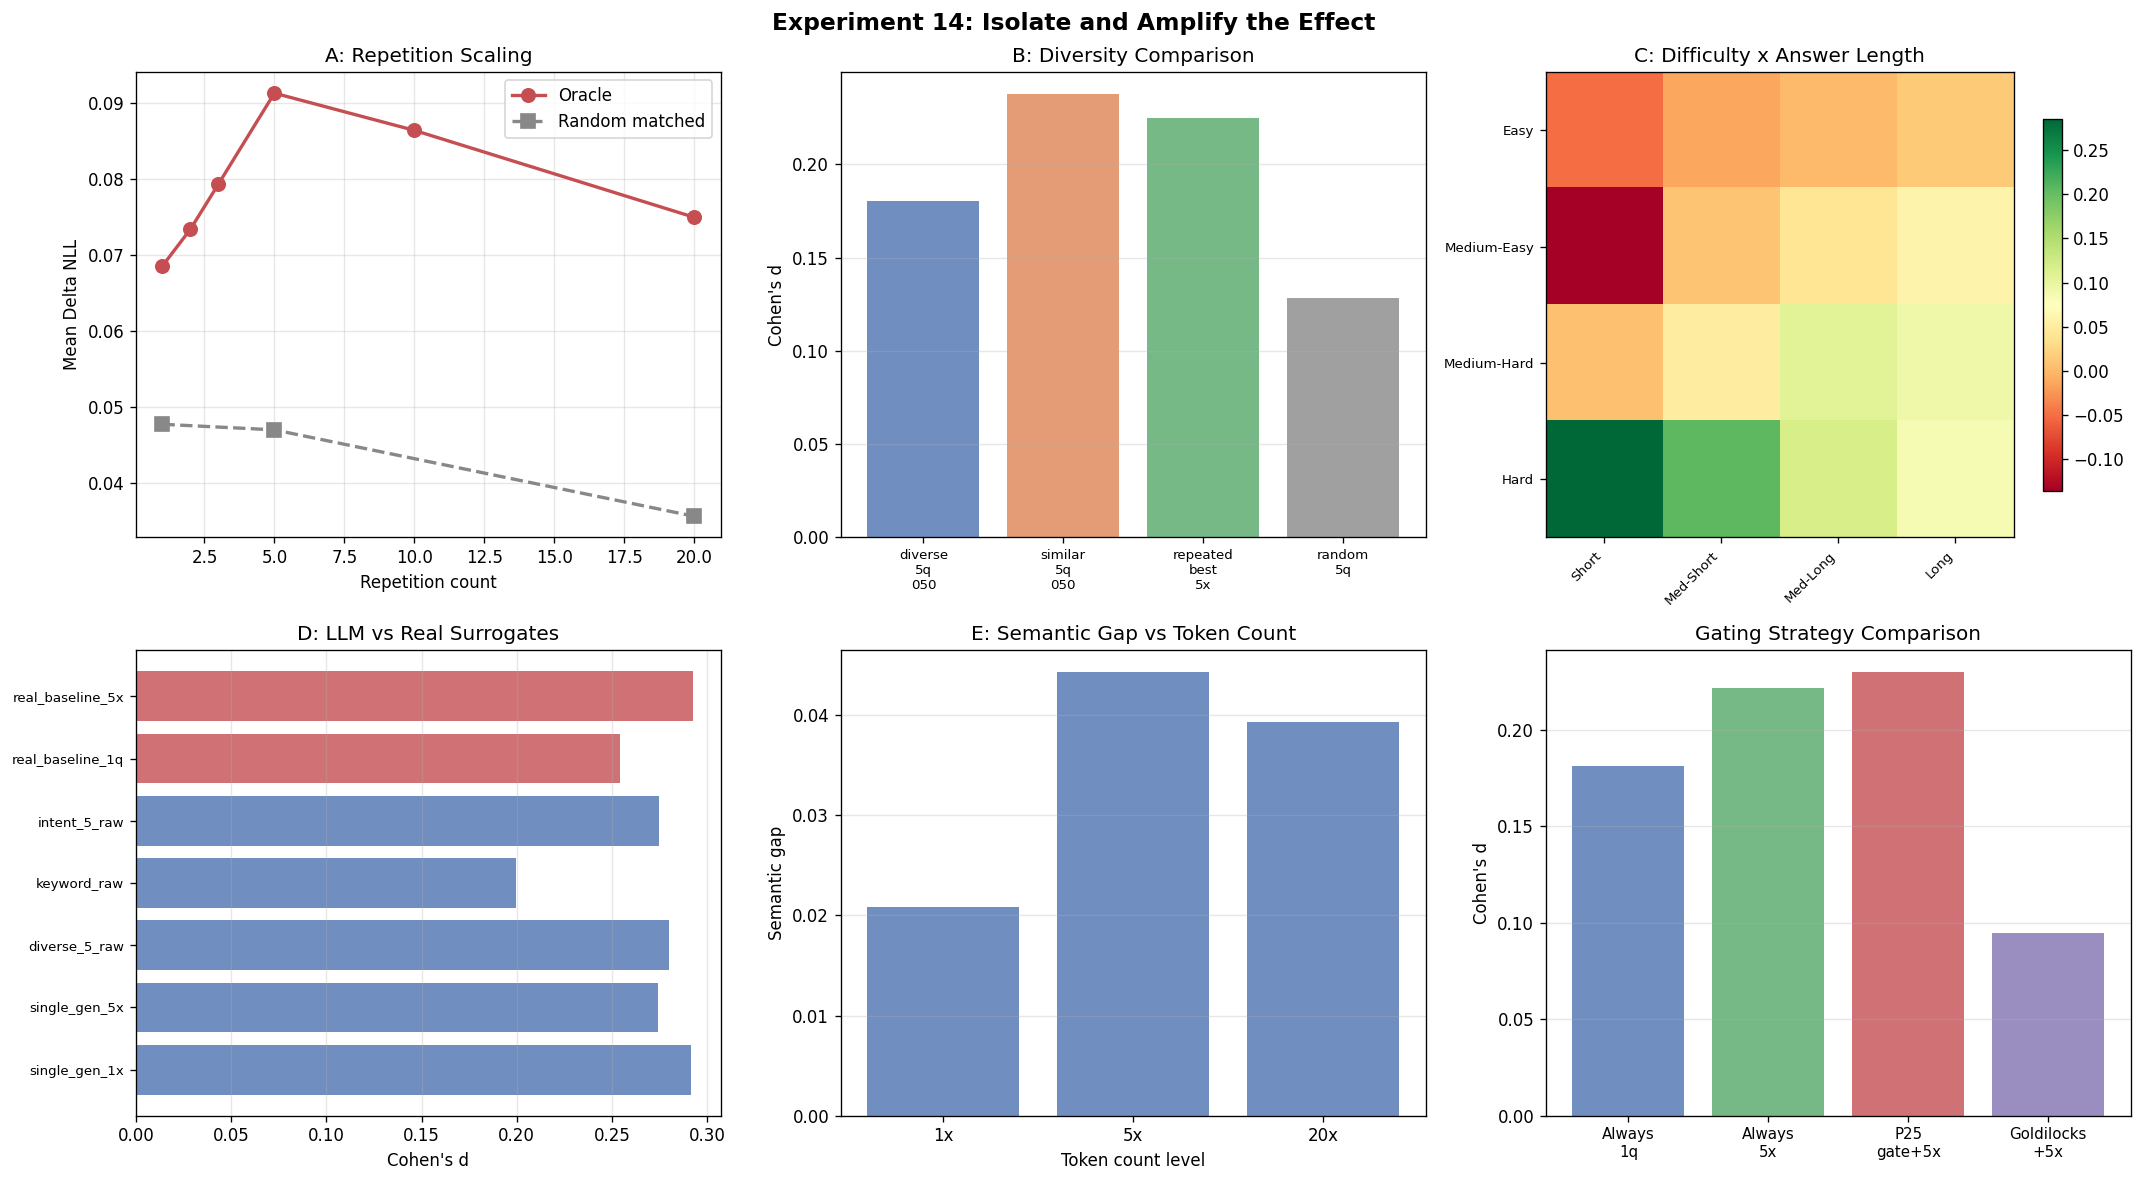

Saved: results/exp14/14_summary.png

EXPERIMENT 14 COMPLETE


In [19]:
# ============================================================
# Save Results + Summary Figures
# ============================================================

output = {
    'metadata': {
        'experiment': '14_isolate_and_amplify',
        'timestamp': datetime.datetime.now().isoformat(),
        'model_name': config.model_name,
        'seed': SEED,
        'n_inv_a': N_INV_A,
        'n_inv_b': len(inv_b_eligible),
        'n_inv_c': N_INV_C,
        'n_inv_d': N_INV_D,
    },
    'inv_a': {
        'n_evaluated': len(results_a), 'skipped': skipped_a, 'errors': errors_a,
        'stats': stats_a,
        'results': results_a,
    },
    'inv_b': {
        'n_evaluated': len(results_b), 'skipped': skipped_b, 'errors': errors_b,
        'n_eligible': len(inv_b_eligible),
        'stats': stats_b,
        'results': results_b,
    },
    'inv_c': {
        'n_evaluated': len(results_c), 'skipped': skipped_c, 'errors': errors_c,
        'stats': {
            'ans_length_r': float(r_ans), 'ans_length_p': float(p_ans),
            'partial_r': float(r_partial), 'partial_p': float(p_partial),
        },
        'results': results_c,
    },
    'inv_d': {
        'n_evaluated': len(results_d), 'skipped': skipped_d, 'errors': errors_d,
        'stats': stats_d,
        'results': results_d,
    },
}

output_path = 'results/exp14/14_results.json'
with open(output_path, 'w') as f:
    json.dump(output, f, indent=2, default=str)
print(f"Results saved to {output_path}")
print(f"File size: {os.path.getsize(output_path) / 1e6:.1f} MB")

# --- Summary figure ---
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# A: Scaling curve
ax = axes[0, 0]
if oracle_reps:
    ax.plot(oracle_reps, oracle_ds, 'o-', color='#c44e52', linewidth=2, markersize=8, label='Oracle')
if random_ds:
    ax.plot([r[0] for r in random_ds], [r[1] for r in random_ds],
            's--', color='#888888', linewidth=2, markersize=8, label='Random matched')
ax.set_xlabel('Repetition count')
ax.set_ylabel('Mean Delta NLL')
ax.set_title('A: Repetition Scaling')
ax.legend()
ax.grid(True, alpha=0.3)

# B: Diversity comparison
ax = axes[0, 1]
b_conds_plot = ['diverse_5q_050', 'similar_5q_050', 'repeated_best_5x', 'random_5q']
b_ds_plot = [stats_b.get(c, {}).get('cohens_d', 0) for c in b_conds_plot]
b_colors_plot = ['#4c72b0', '#dd8452', '#55a868', '#888888']
ax.bar(range(len(b_conds_plot)), b_ds_plot, color=b_colors_plot, alpha=0.8)
ax.set_xticks(range(len(b_conds_plot)))
ax.set_xticklabels([c.replace('_', '\n') for c in b_conds_plot], fontsize=8)
ax.set_ylabel("Cohen's d")
ax.set_title('B: Diversity Comparison')
ax.grid(True, alpha=0.3, axis='y')

# C: Heatmap
ax = axes[0, 2]
im = ax.imshow(heatmap_1q, cmap='RdYlGn', aspect='auto')
ax.set_xticks(range(4))
ax.set_xticklabels(ans_labels, rotation=45, ha='right', fontsize=8)
ax.set_yticks(range(4))
ax.set_yticklabels(nll_labels, fontsize=8)
ax.set_title('C: Difficulty x Answer Length')
plt.colorbar(im, ax=ax, shrink=0.8)

# D: LLM strategies
ax = axes[1, 0]
d_conds_plot = ['single_gen_1x', 'single_gen_5x', 'diverse_5_raw',
                'keyword_raw', 'intent_5_raw',
                'real_baseline_1q', 'real_baseline_5x']
d_ds_plot = [stats_d.get(c, {}).get('cohens_d', 0) for c in d_conds_plot]
d_colors_plot = ['#4c72b0'] * 5 + ['#c44e52'] * 2
ax.barh(range(len(d_conds_plot)), d_ds_plot, color=d_colors_plot, alpha=0.8)
ax.set_yticks(range(len(d_conds_plot)))
ax.set_yticklabels(d_conds_plot, fontsize=8)
ax.set_xlabel("Cohen's d")
ax.set_title('D: LLM vs Real Surrogates')
ax.grid(True, alpha=0.3, axis='x')

# E: Semantic gap
ax = axes[1, 1]
if semantic_gaps:
    sg_x = [s[0] for s in semantic_gaps]
    sg_y = [s[1] for s in semantic_gaps]
    ax.bar(range(len(sg_x)), sg_y, color='#4c72b0', alpha=0.8)
    ax.set_xticks(range(len(sg_x)))
    ax.set_xticklabels([f'{x}x' for x in sg_x])
ax.set_xlabel('Token count level')
ax.set_ylabel('Semantic gap')
ax.set_title('E: Semantic Gap vs Token Count')
ax.grid(True, alpha=0.3, axis='y')

# Gating strategies
ax = axes[1, 2]
gate_names = ['Always\n1q', 'Always\n5x', 'P25\ngate+5x', 'Goldilocks\n+5x']
gate_ds = [d_always_1q, d_always_5x, d_gated_5x, d_gold_5x]
gate_colors = ['#4c72b0', '#55a868', '#c44e52', '#8172b2']
ax.bar(range(len(gate_names)), gate_ds, color=gate_colors, alpha=0.8)
ax.set_xticks(range(len(gate_names)))
ax.set_xticklabels(gate_names, fontsize=9)
ax.set_ylabel("Cohen's d")
ax.set_title('Gating Strategy Comparison')
ax.grid(True, alpha=0.3, axis='y')

fig.suptitle('Experiment 14: Isolate and Amplify the Effect', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('results/exp14/14_summary.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: results/exp14/14_summary.png")

print("\n" + "=" * 80)
print("EXPERIMENT 14 COMPLETE")
print("=" * 80)